In [ ]:
from notebooks import *
print_sys_info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic
platform:
  machine: x86_64
  node: Dan-B.local
  processor: i386
  release: 15.6.0
  system: Darwin
  version: 'Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64'
cpu: 8
mem: 16g
swap: 22g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[16:32:28.549] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
recs_at_least, num_species, num_recs =  20, 168,  20    # ca[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  50   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  20   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  10   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  5    # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          334/35236 (sp/recs)
(downloaded)       334/35232 (sp/recs)
recs_at_least      296/34846 (sp/recs)
num_species        168/19640 (sp/recs)


num_recs            168/3360 (sp/recs)
recs ≥ 2            168/3360 (sp/recs)


'sp[168], recs[3360]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,94080,3360,3360,1,NaN,NaN,True,True,True,True,True
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
id,int64,94080,3360,3360,3360,213283.439,108055.964,1133,138144,193564,308285,416744
sci_name,category,227200,3360,3360,168,NaN,NaN,Anser albifrons,Gelochelidon nilotica,Vireo olivaceus,Parkesia noveboracensis,Spinus tristis
com_name,category,220320,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
subspecies,object,169603,3360,3360,205,NaN,NaN,,,,,zaboria
recordist,object,211728,3360,3360,291,NaN,NaN,AJ Knue,Frank Lambert,Matthias Feuersenger,Peter Boesman,tetiaroa
country,object,203063,3360,3360,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,316516,3360,3360,1740,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Desert Beeline Highway, Maricopa County, Arizona","May Lake, Yosemite NP, California","Sabine Nature Trail loop, Cameron Parish, Louisiana","west of Thorp, WA"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
COGA,205189,True,COGA,207451,Gallinula galeata,Common Gallinule,sandvicensis,Ross Gallardy,United States,"Kailua, Honolulu County, Hawaii",21.4,-158.0,call,B,2014-12-21 00:00:00,07:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/207451,//www.xeno-canto.org/207451/download
INDO,18832,True,INDO,398616,Columbina inca,Inca Dove,,Manuel Grosselet,Mexico,Lomas de Bezares Miguel Hidalgo Mexico city,19.4,-99.2,song,B,2018-01-07 00:00:00,08:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/398616,//www.xeno-canto.org/398616/download
EWPW,223194,True,EWPW,188611,Antrostomus vociferus,Eastern Whip-poor-will,,David Jonas Weber,United States,"Gravelly Hill Rd., Salem County, New Jersey",39.5,-75.4,song,C,2014-07-25 00:00:00,05:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/188611,//www.xeno-canto.org/188611/download
NUWO,113835,True,NUWO,301366,Picoides nuttallii,Nuttall's Woodpecker,,Denise Wight,United States,"Moraga, Contra Costa County, California",37.8,-122.0,"Hawk mobbing call, alarm call",C,2016-01-25 00:00:00,10:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/301366,//www.xeno-canto.org/301366/download
BBWO,80808,True,BBWO,335436,Picoides arcticus,Black-backed Woodpecker,,Lance A. M. Benner,United States,"Blackrock Trailhead, Tulare County, California",36.2,-118.0,"drumming, male",no score,2016-09-17 00:00:00,16:41,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/335436,//www.xeno-canto.org/335436/download
HUVI,117936,True,HUVI,297126,Vireo huttoni,Hutton's Vireo,,Paul Marvin,United States,"Kickapoo Cavern State Park, Brackettville, Texas",29.6,-100.0,song,C,2012-04-08 00:00:00,07:58,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/297126,//www.xeno-canto.org/297126/download
MGWA,89731,True,MGWA,326299,Geothlypis tolmiei,MacGillivray's Warbler,,Lance A. M. Benner,United States,"Buckhorn Campground, San Gabriel Mountains, Los Angeles County, California",34.3,-118.0,"male, song",no score,2016-06-28 00:00:00,10:49,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/326299,//www.xeno-canto.org/326299/download
PUFI,159786,True,PUFI,254326,Haemorhous purpureus,Purple Finch,,Iain,Canada,"Algonquin Highlands, Haliburton County, Ontario",45.3,-78.8,song,C,2015-06-27 00:00:00,11:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/254326,//www.xeno-canto.org/254326/download
CAFI,46804,True,CAFI,369971,Haemorhous cassinii,Cassin's Finch,,Eric DeFonso,United States,"Dunton Rd area, San Juan National Forest, Dolores County, Colorado",37.8,-108.0,song,A,2016-06-28 00:00:00,15:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/369971,//www.xeno-canto.org/369971/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    # xcs_paths[:2],
)

3360

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,171360,3360,3360,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
species_com_name,category,219160,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
species_query,object,178080,3360,3360,168,NaN,NaN,ACWO,CONI,LASP,RIRA,YRWA
duration_s,float64,80640,3360,3360,3054,5.430e+01,7.031e+01,0.697,14.4,31.8,65.4,940
samples_mb,float64,80640,3360,3360,3055,2.286e+00,2.958e+00,0.0293,0.604,1.34,2.76,39.5
samples_n,int64,94080,3360,3360,3055,1.198e+06,1.551e+06,15368,316510,701190,1444435,20731931
basename,object,181440,3360,3360,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,242680,3360,3360,168,NaN,NaN,Greater White-fronted Goose - GWFG,Gull-billed Tern - GBTE,Red-eyed Vireo - REVI,Northern Waterthrush - NOWA,American Goldfinch - AMGO


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,18.3,0.770,403780,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276918/audio,xc/data/GWFG/276918/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,45.0,1.890,991296,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/210100/audio,xc/data/GWFG/210100/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,17.6,0.738,387072,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/323113/audio,xc/data/GWFG/323113/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,24.0,1.010,528142,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276919/audio,xc/data/GWFG/276919/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plot below (7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Greater White-fronted Goose - GWFG,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
1,Gadwall - GADW,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2,American Wigeon - AMWI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3,Mallard - MALL,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4,Green-winged Teal - GWTE,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
5,California Quail - CAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Gambel's Quail - GAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Sooty Grouse - SOGR,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Wild Turkey - WITU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Common Loon - COLO,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = list(unique_everseen([
    dict(
        classifier=[classifier],
        n_species=[n_species if isinstance(n_species, int) else int(n_species * _recs_stats['sp'])],
        n_recs=[
            # n_recs if isinstance(n_recs, int) else int(n_recs * _recs_stats['recs']),
            # TODO Figure out how to represent this as an n instead of a frac again [TODO interaction with test_size=.2 ...]
            #   - TODO Also make clear in the plot descs when e.g. (recs[3360], n_species[33], n_recs[1.0]) -> n_recs[33*20 < 3360]
            n_recs,
        ],
    )
    for (n_species, n_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast

        # (None, None),

        (1.00, 1.00),
        (1.00, 0.50),
        (0.50, 1.00),

        # (0.10, 0.10),  # Faster dev

    ]
    # model_size ~ forest_depth
    for rf_mean_depth_at_168_sp in [93.5]
    for rf_max_depth in [
        'null',
        int(rf_mean_depth_at_168_sp * n_species * 1),
        int(rf_mean_depth_at_168_sp * n_species * 3/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/2),
        int(rf_mean_depth_at_168_sp * n_species * 1/3),
        int(rf_mean_depth_at_168_sp * n_species * 1/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/8),
    ]
    for ovr_rf_max_depth in [int(rf_max_depth / 10) if rf_max_depth != 'null' else 'null']
    for xgb_rf_max_depth in [lambda x: x if x != 'null' else 100]
    # for xgb_rf_max_depth in [
    #     # TODO Run training for all of these
    #     lambda x: 100,
    #     lambda x: 46,
    #     lambda x: 5,
    #     lambda x: 4,
    #     lambda x: 3,
    #     lambda x: 2,
    #     lambda x: 1,
    # ]
    for svm_kernel in ['rbf', 'linear', 'poly']
    for svm_C in [.01, .1, 1, 10]
    for classifier in [

        # RandomForest(entropy)
        #   - 'gini' tends has better accuracy
        # 'cls: rf, criterion: entropy, n_estimators: 200',  # [SP14]

        # RandomForest(gini)
        #
        # WARNING These two are not very mem safe...
        #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
        # 'cls: rf, n_estimators: 2000',
        # 'cls: rf, n_estimators: 1500',
        #
        # 'cls: rf, n_estimators: 1000',
        # 'cls: rf, n_estimators: 800',
        # 'cls: rf, n_estimators: 600',
        # 'cls: rf, n_estimators: 400',
        # 'cls: rf, n_estimators: 200',
        # 'cls: rf, n_estimators: 100',
        # 'cls: rf, n_estimators: 50',
        # 'cls: rf, n_estimators: 10',
        # 'cls: rf, n_estimators: 1',

        # f'cls: xgbm, n_estimators: 100, max_depth: {xgb_rf_max_depth(rf_max_depth)}',
        # f'cls: rf, n_estimators: 100, max_depth: {rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: 80, max_depth: {ovr_rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: 20, max_depth: {ovr_rf_max_depth}',

        # TODO Train these
        # f'cls: xgbm, n_estimators: 100, max_depth: {xgb_rf_max_depth(ovr_rf_max_depth)}',
        # f'cls: xgbm, n_estimators: 50, max_depth: {xgb_rf_max_depth(ovr_rf_max_depth)}',
        # f'cls: xgbm, n_estimators: 25, max_depth: {xgb_rf_max_depth(ovr_rf_max_depth)}',
        # f'cls: ovr-rf, n_estimators: 100, max_depth: {ovr_rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: 50, max_depth: {ovr_rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: 25, max_depth: {ovr_rf_max_depth}',

        # SVM
        f'cls: svm, kernel: {svm_kernel}, C: {svm_C}',  # [SBF16] uses kernel: rbf, C: 10

    ]
]))

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        # n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=2,
        n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # recompute_extra_metrics=True,  # Loads estimator.pkl (fast) but doesn't return it (huge)
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        classes='estimator.classes_',
        train_i='train',
        train_y='y_train',
        train_predict_proba='estimator.classifier_.predict_proba(X_train)',
        test_i='test',
        test_y='y_test',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
        model_size='len(joblib_dumps(estimator))',
        model_stats='model_stats(estimator)',
        proc_stats='proc_stats',
    ),
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # Use n_jobs=1
    #   - All classifiers can parallelize .fit/.predict
    #   - Avoid memory contention
    # n_jobs=1,  # For %prun, and way faster for 100% loads
    # n_jobs=2,
    # n_jobs=8,  # For slow ovr serdes [why?]
    n_jobs=16,  # For recomputing model_stats
    artifacts=dict(
        dir=f'{data_dir}/artifacts',  # TODO Iron out syncing across local/gs/remote
        save=True,
        reuse='20180709-211727-fd34af5-ovr_try_2',
        # skip_compute_if_missing=True,  # TODO Tricky to implement: _fit_and_score_cached needs to be able to return nothing
    ),
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    # stack.enter_context(log.context(level='debug'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[16:32:36.149] INFO   artifacts
  dir: /Users/danb/hack/bubo/features/data/artifacts
  save: true
  reuse: 20180709-211727-fd34af5-ovr_try_2
  experiment_id: 20180709-211727-fd34af5-ovr_try_2


[16:32:36.478] INFO   _fit_and_score: n[1/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit...


[16:32:36.489] INFO   _fit_and_score: n[2/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit...


[16:32:36.520] INFO   _fit_and_score: n[3/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit...


[16:32:36.607] INFO   _fit_and_score: n[4/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit...


[16:32:36.650] INFO   _fit_and_score: n[5/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit...


[16:32:36.692] INFO   _fit_and_score: n[6/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit...


[16:32:36.759] INFO   _fit_and_score: n[7/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit...


[16:32:36.798] INFO   _fit_and_score: n[8/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit...


[16:32:36.879] INFO   _fit_and_score: n[9/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit...


[16:32:36.994] INFO   _fit_and_score: n[10/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit...


[16:32:37.071] INFO   _fit_and_score: n[11/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit...


[16:32:37.136] INFO   _fit_and_score: n[12/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit...


[16:32:37.223] INFO   _fit_and_score: n[13/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit...


[16:32:37.295] INFO   _fit_and_score: n[14/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit...


[16:32:37.355] INFO   _fit_and_score: n[15/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit...


[16:32:37.404] INFO   _fit_and_score: n[16/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit...


[16:36:43.214] INFO   _fit_and_score: n[14/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit[244.925s]


[16:36:43.826] INFO   _fit_and_score: n[14/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:36:43.941] INFO   _fit_and_score: n[13/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit[245.710s]


[16:36:44.252] INFO   _fit_and_score: n[16/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit[245.919s]


[16:36:44.810] INFO   _fit_and_score: n[13/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:36:44.887] INFO   _fit_and_score: n[16/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:36:45.578] INFO   _fit_and_score: n[15/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit[247.264s]


[16:36:45.928] INFO   _fit_and_score: n[15/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:37:37.491] INFO   _fit_and_score: n[14/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics[53.633s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:37:37.495] INFO   _fit_and_score: n[14/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: ret...


[16:37:37.571] INFO   _fit_and_score: n[14/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.070s, 4.7 MB]: ret


[16:37:37.598] INFO   _fit_and_score: n[14/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: estimator...


[16:37:37.797] INFO   _fit_and_score: n[14/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.185s, 55.6 MB]: estimator


[16:37:38.007] INFO   _fit_and_score: n[17/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit...


[16:37:39.400] INFO   _fit_and_score: n[13/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics[54.537s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:37:39.404] INFO   _fit_and_score: n[13/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: ret...


[16:37:39.479] INFO   _fit_and_score: n[13/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.062s, 4.7 MB]: ret


[16:37:39.504] INFO   _fit_and_score: n[13/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: estimator...


[16:37:39.694] INFO   _fit_and_score: n[13/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.187s, 55.7 MB]: estimator


[16:37:39.880] INFO   _fit_and_score: n[18/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit...


[16:37:39.906] INFO   _fit_and_score: n[16/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics[54.941s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:37:39.909] INFO   _fit_and_score: n[16/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: ret...


[16:37:39.977] INFO   _fit_and_score: n[16/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.053s, 4.7 MB]: ret


[16:37:40.003] INFO   _fit_and_score: n[16/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: estimator...


[16:37:40.207] INFO   _fit_and_score: n[16/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.178s, 55.7 MB]: estimator


[16:37:40.395] INFO   _fit_and_score: n[19/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit...


[16:37:41.791] INFO   _fit_and_score: n[15/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics[55.799s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:37:41.795] INFO   _fit_and_score: n[15/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: ret...


[16:37:41.876] INFO   _fit_and_score: n[15/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.078s, 4.7 MB]: ret


[16:37:41.884] INFO   _fit_and_score: n[15/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: estimator...


[16:37:42.089] INFO   _fit_and_score: n[15/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.202s, 55.7 MB]: estimator


[16:37:42.286] INFO   _fit_and_score: n[20/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit...


[16:38:54.811] INFO   _fit_and_score: n[1/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit[377.829s]


[16:38:55.172] INFO   _fit_and_score: n[1/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:38:55.575] INFO   _fit_and_score: n[2/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit[378.486s]


[16:38:55.592] INFO   _fit_and_score: n[3/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit[378.290s]


[16:38:56.002] INFO   _fit_and_score: n[5/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit[378.478s]


[16:38:56.053] INFO   _fit_and_score: n[4/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit[378.521s]


[16:38:56.205] INFO   _fit_and_score: n[4/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:38:56.429] INFO   _fit_and_score: n[5/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:38:56.642] INFO   _fit_and_score: n[2/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:38:56.647] INFO   _fit_and_score: n[3/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:38:56.832] INFO   _fit_and_score: n[6/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit[379.133s]


[16:38:57.438] INFO   _fit_and_score: n[6/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:38:57.539] INFO   _fit_and_score: n[7/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit[379.698s]


[16:38:57.759] INFO   _fit_and_score: n[7/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:38:57.761] INFO   _fit_and_score: n[8/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit[379.674s]


[16:38:58.206] INFO   _fit_and_score: n[9/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit[380.047s]


[16:38:58.393] INFO   _fit_and_score: n[8/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:38:58.981] INFO   _fit_and_score: n[9/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:38:59.557] INFO   _fit_and_score: n[10/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit[381.383s]


[16:39:00.080] INFO   _fit_and_score: n[12/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit[381.839s]


[16:39:00.268] INFO   _fit_and_score: n[11/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit[382.101s]


[16:39:00.416] INFO   _fit_and_score: n[10/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:39:01.132] INFO   _fit_and_score: n[12/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:39:01.329] INFO   _fit_and_score: n[11/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:15.849] INFO   _fit_and_score: n[1/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics[80.627s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:15.852] INFO   _fit_and_score: n[1/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: ret...


[16:40:15.907] INFO   _fit_and_score: n[1/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.052s, 4.7 MB]: ret


[16:40:15.938] INFO   _fit_and_score: n[1/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: estimator...


[16:40:16.139] INFO   _fit_and_score: n[1/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.176s, 56.1 MB]: estimator


[16:40:16.311] INFO   _fit_and_score: n[21/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit...


[16:40:16.892] INFO   _fit_and_score: n[5/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics[80.392s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:16.895] INFO   _fit_and_score: n[5/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: ret...


[16:40:16.965] INFO   _fit_and_score: n[5/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.057s, 4.7 MB]: ret


[16:40:16.971] INFO   _fit_and_score: n[5/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: estimator...


[16:40:17.163] INFO   _fit_and_score: n[5/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.190s, 56.1 MB]: estimator


[16:40:17.330] INFO   _fit_and_score: n[22/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit...


[16:40:17.419] INFO   _fit_and_score: n[4/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics[81.143s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:17.442] INFO   _fit_and_score: n[4/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: ret...


[16:40:17.492] INFO   _fit_and_score: n[4/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.027s, 4.7 MB]: ret


[16:40:17.495] INFO   _fit_and_score: n[4/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: estimator...


[16:40:17.495] INFO   _fit_and_score: n[2/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics[80.775s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:17.501] INFO   _fit_and_score: n[2/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: ret...


[16:40:17.546] INFO   _fit_and_score: n[2/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.042s, 4.7 MB]: ret


[16:40:17.564] INFO   _fit_and_score: n[2/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: estimator...


[16:40:17.714] INFO   _fit_and_score: n[4/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.216s, 56.1 MB]: estimator


[16:40:17.813] INFO   _fit_and_score: n[2/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.226s, 56.1 MB]: estimator


[16:40:17.878] INFO   _fit_and_score: n[23/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit...


[16:40:18.005] INFO   _fit_and_score: n[24/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit...


[16:40:18.044] INFO   _fit_and_score: n[3/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics[81.323s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:18.067] INFO   _fit_and_score: n[3/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: ret...


[16:40:18.119] INFO   _fit_and_score: n[3/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.025s, 4.7 MB]: ret


[16:40:18.143] INFO   _fit_and_score: n[3/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: estimator...


[16:40:18.303] INFO   _fit_and_score: n[3/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.157s, 56.1 MB]: estimator


[16:40:18.472] INFO   _fit_and_score: n[25/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit...


[16:40:18.875] INFO   _fit_and_score: n[6/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics[81.372s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:18.879] INFO   _fit_and_score: n[6/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: ret...


[16:40:18.923] INFO   _fit_and_score: n[6/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.030s, 4.7 MB]: ret


[16:40:18.946] INFO   _fit_and_score: n[6/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: estimator...


[16:40:19.120] INFO   _fit_and_score: n[6/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.149s, 56.1 MB]: estimator


[16:40:19.265] INFO   _fit_and_score: n[26/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit...


[16:40:19.858] INFO   _fit_and_score: n[7/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics[82.048s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:19.861] INFO   _fit_and_score: n[7/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: ret...


[16:40:19.910] INFO   _fit_and_score: n[7/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.046s, 4.7 MB]: ret


[16:40:19.912] INFO   _fit_and_score: n[7/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: estimator...


[16:40:20.099] INFO   _fit_and_score: n[7/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.185s, 56.1 MB]: estimator


[16:40:20.258] INFO   _fit_and_score: n[27/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit...


[16:40:20.692] INFO   _fit_and_score: n[8/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics[82.229s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:20.717] INFO   _fit_and_score: n[8/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: ret...


[16:40:20.763] INFO   _fit_and_score: n[8/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.022s, 4.7 MB]: ret


[16:40:20.768] INFO   _fit_and_score: n[8/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: estimator...


[16:40:20.939] INFO   _fit_and_score: n[8/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.168s, 56.1 MB]: estimator


[16:40:21.086] INFO   _fit_and_score: n[28/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit...


[16:40:21.470] INFO   _fit_and_score: n[9/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics[82.456s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:21.472] INFO   _fit_and_score: n[9/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: ret...


[16:40:21.498] INFO   _fit_and_score: n[9/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.024s, 4.7 MB]: ret


[16:40:21.501] INFO   _fit_and_score: n[9/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: estimator...


[16:40:21.676] INFO   _fit_and_score: n[9/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.172s, 56.0 MB]: estimator


[16:40:21.829] INFO   _fit_and_score: n[29/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit...


[16:40:22.040] INFO   _fit_and_score: n[10/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics[81.565s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:22.042] INFO   _fit_and_score: n[10/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: ret...


[16:40:22.084] INFO   _fit_and_score: n[10/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.040s, 4.7 MB]: ret


[16:40:22.110] INFO   _fit_and_score: n[10/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: estimator...


[16:40:22.294] INFO   _fit_and_score: n[10/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.160s, 56.1 MB]: estimator


[16:40:22.424] INFO   _fit_and_score: n[30/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit...


[16:40:22.795] INFO   _fit_and_score: n[11/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics[81.416s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:22.797] INFO   _fit_and_score: n[11/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: ret...


[16:40:22.866] INFO   _fit_and_score: n[11/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.040s, 4.7 MB]: ret


[16:40:22.878] INFO   _fit_and_score: n[11/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: estimator...


[16:40:22.889] INFO   _fit_and_score: n[12/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics[81.699s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:40:22.892] INFO   _fit_and_score: n[12/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: ret...


[16:40:22.927] INFO   _fit_and_score: n[12/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.031s, 4.7 MB]: ret


[16:40:22.930] INFO   _fit_and_score: n[12/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: estimator...


[16:40:23.130] INFO   _fit_and_score: n[11/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.239s, 56.1 MB]: estimator


[16:40:23.217] INFO   _fit_and_score: n[12/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.257s, 56.1 MB]: estimator


[16:40:23.287] INFO   _fit_and_score: n[31/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit...


[16:40:23.395] INFO   _fit_and_score: n[32/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit...


[16:41:41.910] INFO   _fit_and_score: n[17/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit[242.953s]


[16:41:42.744] INFO   _fit_and_score: n[17/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:41:44.571] INFO   _fit_and_score: n[19/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit[243.307s]


[16:41:44.913] INFO   _fit_and_score: n[19/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:41:45.123] INFO   _fit_and_score: n[20/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit[242.061s]


[16:41:45.770] INFO   _fit_and_score: n[20/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:41:45.826] INFO   _fit_and_score: n[18/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit[244.938s]


[16:41:46.520] INFO   _fit_and_score: n[18/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:42:31.746] INFO   _fit_and_score: n[17/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics[48.969s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:42:31.768] INFO   _fit_and_score: n[17/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: ret...


[16:42:31.797] INFO   _fit_and_score: n[17/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.026s, 4.7 MB]: ret


[16:42:31.800] INFO   _fit_and_score: n[17/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: estimator...


[16:42:31.964] INFO   _fit_and_score: n[17/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.162s, 55.6 MB]: estimator


[16:42:32.100] INFO   _fit_and_score: n[33/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit...


[16:42:34.029] INFO   _fit_and_score: n[19/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics[49.090s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:42:34.043] INFO   _fit_and_score: n[19/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: ret...


[16:42:34.084] INFO   _fit_and_score: n[19/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.039s, 4.7 MB]: ret


[16:42:34.088] INFO   _fit_and_score: n[19/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: estimator...


[16:42:34.259] INFO   _fit_and_score: n[19/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.169s, 55.7 MB]: estimator


[16:42:34.417] INFO   _fit_and_score: n[34/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed: 10.0min


[16:42:34.935] INFO   _fit_and_score: n[20/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics[49.136s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:42:34.948] INFO   _fit_and_score: n[20/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: ret...


[16:42:34.975] INFO   _fit_and_score: n[20/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.023s, 4.7 MB]: ret


[16:42:34.978] INFO   _fit_and_score: n[20/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: estimator...


[16:42:35.197] INFO   _fit_and_score: n[20/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.217s, 55.6 MB]: estimator


[16:42:35.352] INFO   _fit_and_score: n[35/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit...


[16:42:36.009] INFO   _fit_and_score: n[18/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics[49.438s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:42:36.022] INFO   _fit_and_score: n[18/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: ret...


[16:42:36.070] INFO   _fit_and_score: n[18/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.024s, 4.7 MB]: ret


[16:42:36.093] INFO   _fit_and_score: n[18/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: estimator...


[16:42:36.242] INFO   _fit_and_score: n[18/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.146s, 55.7 MB]: estimator


[16:42:36.370] INFO   _fit_and_score: n[36/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit...


[16:44:01.201] INFO   _fit_and_score: n[31/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit[217.430s]


[16:44:02.130] INFO   _fit_and_score: n[31/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:02.833] INFO   _fit_and_score: n[32/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit[218.955s]


[16:44:03.402] INFO   _fit_and_score: n[32/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:10.249] INFO   _fit_and_score: n[28/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit[228.660s]


[16:44:11.113] INFO   _fit_and_score: n[28/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:11.209] INFO   _fit_and_score: n[29/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit[228.857s]


[16:44:11.810] INFO   _fit_and_score: n[29/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:13.743] INFO   _fit_and_score: n[30/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit[230.793s]


[16:44:14.528] INFO   _fit_and_score: n[30/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:40.998] INFO   _fit_and_score: n[25/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit[261.865s]


[16:44:41.263] INFO   _fit_and_score: n[26/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit[261.463s]


[16:44:41.770] INFO   _fit_and_score: n[26/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:42.042] INFO   _fit_and_score: n[25/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:42.895] INFO   _fit_and_score: n[23/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit[264.252s]


[16:44:43.471] INFO   _fit_and_score: n[23/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:43.789] INFO   _fit_and_score: n[22/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit[265.683s]


[16:44:44.083] INFO   _fit_and_score: n[22/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:44.623] INFO   _fit_and_score: n[27/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit[263.870s]


[16:44:45.136] INFO   _fit_and_score: n[21/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit[268.124s]


[16:44:45.619] INFO   _fit_and_score: n[27/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:45.883] INFO   _fit_and_score: n[21/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:44:46.401] INFO   _fit_and_score: n[24/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit[267.670s]


[16:44:46.886] INFO   _fit_and_score: n[24/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:45:21.303] INFO   _fit_and_score: n[31/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics[79.144s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:45:21.307] INFO   _fit_and_score: n[31/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: ret...


[16:45:21.354] INFO   _fit_and_score: n[31/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.045s, 4.7 MB]: ret


[16:45:21.357] INFO   _fit_and_score: n[31/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: estimator...


[16:45:21.571] INFO   _fit_and_score: n[31/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.210s, 55.2 MB]: estimator


[16:45:21.761] INFO   _fit_and_score: n[37/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit...


[16:45:22.093] INFO   _fit_and_score: n[32/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics[78.635s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:45:22.096] INFO   _fit_and_score: n[32/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: ret...


[16:45:22.141] INFO   _fit_and_score: n[32/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.042s, 4.7 MB]: ret


[16:45:22.144] INFO   _fit_and_score: n[32/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: estimator...


[16:45:22.331] INFO   _fit_and_score: n[32/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.184s, 55.1 MB]: estimator


[16:45:22.486] INFO   _fit_and_score: n[38/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit...


[16:45:32.044] INFO   _fit_and_score: n[28/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics[80.882s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:45:32.050] INFO   _fit_and_score: n[28/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: ret...


[16:45:32.105] INFO   _fit_and_score: n[28/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.052s, 4.7 MB]: ret


[16:45:32.119] INFO   _fit_and_score: n[28/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: estimator...


[16:45:32.294] INFO   _fit_and_score: n[28/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.162s, 55.1 MB]: estimator


[16:45:32.334] INFO   _fit_and_score: n[29/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics[80.418s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:45:32.357] INFO   _fit_and_score: n[29/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: ret...


[16:45:32.406] INFO   _fit_and_score: n[29/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.024s, 4.7 MB]: ret


[16:45:32.419] INFO   _fit_and_score: n[29/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: estimator...


[16:45:32.455] INFO   _fit_and_score: n[39/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit...


[16:45:32.588] INFO   _fit_and_score: n[29/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.155s, 55.1 MB]: estimator


[16:45:32.741] INFO   _fit_and_score: n[40/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit...


[16:45:35.206] INFO   _fit_and_score: n[30/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics[80.626s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:45:35.208] INFO   _fit_and_score: n[30/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: ret...


[16:45:35.286] INFO   _fit_and_score: n[30/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.076s, 4.7 MB]: ret


[16:45:35.297] INFO   _fit_and_score: n[30/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: estimator...


[16:45:35.464] INFO   _fit_and_score: n[30/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.165s, 55.2 MB]: estimator


[16:45:35.617] INFO   _fit_and_score: n[41/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit...


[16:46:01.355] INFO   _fit_and_score: n[26/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics[79.521s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:01.358] INFO   _fit_and_score: n[26/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: ret...


[16:46:01.403] INFO   _fit_and_score: n[26/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.042s, 4.7 MB]: ret


[16:46:01.416] INFO   _fit_and_score: n[26/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: estimator...


[16:46:01.434] INFO   _fit_and_score: n[25/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics[79.356s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:01.446] INFO   _fit_and_score: n[25/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: ret...


[16:46:01.505] INFO   _fit_and_score: n[25/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.056s, 4.7 MB]: ret


[16:46:01.530] INFO   _fit_and_score: n[25/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: estimator...


[16:46:01.607] INFO   _fit_and_score: n[26/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.189s, 55.4 MB]: estimator


[16:46:01.738] INFO   _fit_and_score: n[25/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.183s, 55.5 MB]: estimator


[16:46:01.775] INFO   _fit_and_score: n[42/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit...


[16:46:01.893] INFO   _fit_and_score: n[43/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit...


[16:46:03.867] INFO   _fit_and_score: n[23/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics[80.365s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:03.870] INFO   _fit_and_score: n[23/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: ret...


[16:46:03.923] INFO   _fit_and_score: n[23/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.051s, 4.7 MB]: ret


[16:46:03.927] INFO   _fit_and_score: n[23/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: estimator...


[16:46:04.089] INFO   _fit_and_score: n[23/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.157s, 55.6 MB]: estimator


[16:46:04.245] INFO   _fit_and_score: n[44/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit...


[16:46:04.612] INFO   _fit_and_score: n[22/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics[80.479s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:04.616] INFO   _fit_and_score: n[22/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: ret...


[16:46:04.667] INFO   _fit_and_score: n[22/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.049s, 4.7 MB]: ret


[16:46:04.689] INFO   _fit_and_score: n[22/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: estimator...


[16:46:04.852] INFO   _fit_and_score: n[22/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.160s, 55.7 MB]: estimator


[16:46:04.958] INFO   _fit_and_score: n[27/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics[79.291s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:05.001] INFO   _fit_and_score: n[27/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: ret...


[16:46:05.011] INFO   _fit_and_score: n[45/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit...


[16:46:05.050] INFO   _fit_and_score: n[27/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.026s, 4.7 MB]: ret


[16:46:05.073] INFO   _fit_and_score: n[27/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: estimator...


[16:46:05.238] INFO   _fit_and_score: n[27/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.162s, 55.4 MB]: estimator


[16:46:05.374] INFO   _fit_and_score: n[46/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit...


[16:46:05.942] INFO   _fit_and_score: n[21/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics[80.020s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:05.947] INFO   _fit_and_score: n[21/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: ret...


[16:46:05.989] INFO   _fit_and_score: n[21/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.039s, 4.7 MB]: ret


[16:46:05.993] INFO   _fit_and_score: n[21/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: estimator...


[16:46:06.181] INFO   _fit_and_score: n[21/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.174s, 55.7 MB]: estimator


[16:46:06.323] INFO   _fit_and_score: n[47/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit...


[16:46:06.702] INFO   _fit_and_score: n[24/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics[79.784s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:06.705] INFO   _fit_and_score: n[24/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: ret...


[16:46:06.772] INFO   _fit_and_score: n[24/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.054s, 4.7 MB]: ret


[16:46:06.775] INFO   _fit_and_score: n[24/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: estimator...


[16:46:06.964] INFO   _fit_and_score: n[24/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.185s, 55.7 MB]: estimator


[16:46:07.097] INFO   _fit_and_score: n[48/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit...


[16:46:23.366] INFO   _fit_and_score: n[34/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit[228.414s]


[16:46:23.381] INFO   _fit_and_score: n[33/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit[230.808s]


[16:46:23.472] INFO   _fit_and_score: n[34/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:24.107] INFO   _fit_and_score: n[33/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:24.367] INFO   _fit_and_score: n[35/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit[228.574s]


[16:46:25.177] INFO   _fit_and_score: n[36/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit[228.372s]


[16:46:25.352] INFO   _fit_and_score: n[36/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:46:25.354] INFO   _fit_and_score: n[35/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:15.855] INFO   _fit_and_score: n[37/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit[113.218s]


[16:47:15.944] INFO   _fit_and_score: n[37/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:16.522] INFO   _fit_and_score: n[34/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics[53.012s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:16.525] INFO   _fit_and_score: n[34/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: ret...


[16:47:16.579] INFO   _fit_and_score: n[34/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.051s, 4.7 MB]: ret


[16:47:16.602] INFO   _fit_and_score: n[34/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: estimator...


[16:47:16.774] INFO   _fit_and_score: n[34/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.168s, 55.2 MB]: estimator


[16:47:16.901] INFO   _fit_and_score: n[38/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit[113.571s]


[16:47:16.921] INFO   _fit_and_score: n[49/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit...


[16:47:17.342] INFO   _fit_and_score: n[33/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics[53.171s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:17.346] INFO   _fit_and_score: n[33/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: ret...


[16:47:17.384] INFO   _fit_and_score: n[33/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.036s, 4.7 MB]: ret


[16:47:17.387] INFO   _fit_and_score: n[33/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: estimator...


[16:47:17.559] INFO   _fit_and_score: n[38/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:17.567] INFO   _fit_and_score: n[33/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.177s, 55.2 MB]: estimator


[16:47:17.750] INFO   _fit_and_score: n[50/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit...


[16:47:18.162] INFO   _fit_and_score: n[35/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics[52.758s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:18.167] INFO   _fit_and_score: n[35/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: ret...


[16:47:18.216] INFO   _fit_and_score: n[35/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.047s, 4.7 MB]: ret


[16:47:18.239] INFO   _fit_and_score: n[35/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: estimator...


[16:47:18.416] INFO   _fit_and_score: n[35/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.175s, 55.1 MB]: estimator


[16:47:18.549] INFO   _fit_and_score: n[51/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit...


[16:47:18.981] INFO   _fit_and_score: n[36/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics[53.567s, 4.7 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:18.985] INFO   _fit_and_score: n[36/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: ret...


[16:47:19.023] INFO   _fit_and_score: n[36/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.034s, 4.7 MB]: ret


[16:47:19.025] INFO   _fit_and_score: n[36/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: estimator...


[16:47:19.223] INFO   _fit_and_score: n[36/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.194s, 55.2 MB]: estimator


[16:47:19.387] INFO   _fit_and_score: n[52/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit...


[16:47:26.680] INFO   _fit_and_score: n[39/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit[113.350s]


[16:47:27.591] INFO   _fit_and_score: n[39/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:27.788] INFO   _fit_and_score: n[40/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit[114.214s]


[16:47:28.840] INFO   _fit_and_score: n[40/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:31.150] INFO   _fit_and_score: n[41/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit[114.756s]


[16:47:31.647] INFO   _fit_and_score: n[41/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:49.200] INFO   _fit_and_score: n[37/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics[33.206s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:49.213] INFO   _fit_and_score: n[37/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: ret...


[16:47:49.268] INFO   _fit_and_score: n[37/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.052s, 4.6 MB]: ret


[16:47:49.291] INFO   _fit_and_score: n[37/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: estimator...


[16:47:49.403] INFO   _fit_and_score: n[37/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.109s, 28.3 MB]: estimator


[16:47:49.572] INFO   _fit_and_score: n[53/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit...


[16:47:50.706] INFO   _fit_and_score: n[38/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics[33.096s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:47:50.709] INFO   _fit_and_score: n[38/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: ret...


[16:47:50.769] INFO   _fit_and_score: n[38/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.057s, 4.6 MB]: ret


[16:47:50.781] INFO   _fit_and_score: n[38/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: estimator...


[16:47:50.892] INFO   _fit_and_score: n[38/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.088s, 28.3 MB]: estimator


[16:47:51.062] INFO   _fit_and_score: n[54/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit...


[16:47:57.710] INFO   _fit_and_score: n[42/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit[115.253s]


[16:47:57.818] INFO   _fit_and_score: n[42/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:01.041] INFO   _fit_and_score: n[43/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit[118.493s]


[16:48:01.649] INFO   _fit_and_score: n[39/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics[33.993s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:01.652] INFO   _fit_and_score: n[39/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: ret...


[16:48:01.709] INFO   _fit_and_score: n[39/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.055s, 4.6 MB]: ret


[16:48:01.722] INFO   _fit_and_score: n[39/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: estimator...


[16:48:01.817] INFO   _fit_and_score: n[39/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.092s, 28.3 MB]: estimator


[16:48:01.851] INFO   _fit_and_score: n[43/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:01.987] INFO   _fit_and_score: n[55/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit...


[16:48:03.155] INFO   _fit_and_score: n[44/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit[118.323s]


[16:48:03.929] INFO   _fit_and_score: n[40/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics[35.060s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:03.931] INFO   _fit_and_score: n[40/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: ret...


[16:48:03.977] INFO   _fit_and_score: n[40/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.043s, 4.6 MB]: ret


[16:48:03.992] INFO   _fit_and_score: n[40/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: estimator...


[16:48:04.074] INFO   _fit_and_score: n[45/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit[118.458s]


[16:48:04.085] INFO   _fit_and_score: n[40/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.080s, 28.3 MB]: estimator


[16:48:04.152] INFO   _fit_and_score: n[44/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:04.223] INFO   _fit_and_score: n[56/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit...


[16:48:04.741] INFO   _fit_and_score: n[46/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit[118.808s]


[16:48:04.887] INFO   _fit_and_score: n[45/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:05.239] INFO   _fit_and_score: n[46/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:05.502] INFO   _fit_and_score: n[47/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit[118.641s]


[16:48:06.117] INFO   _fit_and_score: n[48/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit[118.590s]


[16:48:06.185] INFO   _fit_and_score: n[47/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:06.659] INFO   _fit_and_score: n[41/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics[34.964s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:06.672] INFO   _fit_and_score: n[41/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: ret...


[16:48:06.721] INFO   _fit_and_score: n[41/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.024s, 4.6 MB]: ret


[16:48:06.745] INFO   _fit_and_score: n[41/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: estimator...


[16:48:06.842] INFO   _fit_and_score: n[41/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.093s, 28.3 MB]: estimator


[16:48:06.901] INFO   _fit_and_score: n[48/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:07.007] INFO   _fit_and_score: n[57/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit...


[16:48:30.744] INFO   _fit_and_score: n[42/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics[32.878s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:30.757] INFO   _fit_and_score: n[42/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: ret...


[16:48:30.819] INFO   _fit_and_score: n[42/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.059s, 4.6 MB]: ret


[16:48:30.822] INFO   _fit_and_score: n[42/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: estimator...


[16:48:30.952] INFO   _fit_and_score: n[42/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.127s, 28.3 MB]: estimator


[16:48:31.094] INFO   _fit_and_score: n[58/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit...


[16:48:36.902] INFO   _fit_and_score: n[43/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics[34.990s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:36.925] INFO   _fit_and_score: n[43/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: ret...


[16:48:36.951] INFO   _fit_and_score: n[43/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.023s, 4.6 MB]: ret


[16:48:36.954] INFO   _fit_and_score: n[43/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: estimator...


[16:48:37.075] INFO   _fit_and_score: n[43/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.117s, 28.3 MB]: estimator


[16:48:37.221] INFO   _fit_and_score: n[59/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit...


[16:48:39.140] INFO   _fit_and_score: n[44/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics[34.938s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:39.157] INFO   _fit_and_score: n[44/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: ret...


[16:48:39.222] INFO   _fit_and_score: n[44/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.042s, 4.6 MB]: ret


[16:48:39.225] INFO   _fit_and_score: n[44/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: estimator...


[16:48:39.346] INFO   _fit_and_score: n[44/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.117s, 28.3 MB]: estimator


[16:48:39.482] INFO   _fit_and_score: n[60/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit...


[16:48:40.127] INFO   _fit_and_score: n[45/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics[35.191s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:40.129] INFO   _fit_and_score: n[45/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: ret...


[16:48:40.183] INFO   _fit_and_score: n[45/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.052s, 4.6 MB]: ret


[16:48:40.207] INFO   _fit_and_score: n[45/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: estimator...


[16:48:40.320] INFO   _fit_and_score: n[45/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.109s, 28.3 MB]: estimator


[16:48:40.454] INFO   _fit_and_score: n[46/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics[35.164s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:40.467] INFO   _fit_and_score: n[46/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: ret...


[16:48:40.469] INFO   _fit_and_score: n[61/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit...


[16:48:40.511] INFO   _fit_and_score: n[46/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.042s, 4.6 MB]: ret


[16:48:40.514] INFO   _fit_and_score: n[46/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: estimator...


[16:48:40.638] INFO   _fit_and_score: n[46/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.121s, 28.3 MB]: estimator


[16:48:40.772] INFO   _fit_and_score: n[62/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit...


[16:48:41.671] INFO   _fit_and_score: n[47/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics[35.442s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:41.685] INFO   _fit_and_score: n[47/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: ret...


[16:48:41.733] INFO   _fit_and_score: n[47/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.025s, 4.6 MB]: ret


[16:48:41.735] INFO   _fit_and_score: n[47/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: estimator...


[16:48:41.846] INFO   _fit_and_score: n[47/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.108s, 28.3 MB]: estimator


[16:48:41.988] INFO   _fit_and_score: n[63/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit...


[16:48:42.475] INFO   _fit_and_score: n[48/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics[35.515s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:42.482] INFO   _fit_and_score: n[48/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: ret...


[16:48:42.520] INFO   _fit_and_score: n[48/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.036s, 4.6 MB]: ret


[16:48:42.523] INFO   _fit_and_score: n[48/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: estimator...


[16:48:42.640] INFO   _fit_and_score: n[48/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.114s, 28.3 MB]: estimator


[16:48:42.769] INFO   _fit_and_score: n[64/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit...


[16:48:54.499] INFO   _fit_and_score: n[49/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit[97.048s]


[16:48:54.712] INFO   _fit_and_score: n[50/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit[96.476s]


[16:48:55.256] INFO   _fit_and_score: n[50/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:55.501] INFO   _fit_and_score: n[49/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:55.516] INFO   _fit_and_score: n[51/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit[96.452s]


[16:48:56.110] INFO   _fit_and_score: n[51/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:48:56.491] INFO   _fit_and_score: n[52/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit[96.681s]


[16:48:56.841] INFO   _fit_and_score: n[52/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:25.569] INFO   _fit_and_score: n[53/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit[95.425s]


[16:49:26.195] INFO   _fit_and_score: n[53/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:26.608] INFO   _fit_and_score: n[50/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics[31.303s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:26.610] INFO   _fit_and_score: n[50/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: ret...


[16:49:26.665] INFO   _fit_and_score: n[50/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.052s, 4.6 MB]: ret


[16:49:26.667] INFO   _fit_and_score: n[50/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: estimator...


[16:49:26.803] INFO   _fit_and_score: n[50/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.118s, 28.2 MB]: estimator


[16:49:26.977] INFO   _fit_and_score: n[65/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit...


[16:49:27.248] INFO   _fit_and_score: n[49/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics[31.720s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:27.251] INFO   _fit_and_score: n[49/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: ret...


[16:49:27.314] INFO   _fit_and_score: n[49/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.061s, 4.6 MB]: ret


[16:49:27.327] INFO   _fit_and_score: n[49/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: estimator...


[16:49:27.435] INFO   _fit_and_score: n[49/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.085s, 28.2 MB]: estimator


[16:49:27.454] INFO   _fit_and_score: n[54/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit[95.913s]


[16:49:27.554] INFO   _fit_and_score: n[54/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:27.589] INFO   _fit_and_score: n[66/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit...


[16:49:27.665] INFO   _fit_and_score: n[51/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics[31.489s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:27.667] INFO   _fit_and_score: n[51/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: ret...


[16:49:27.715] INFO   _fit_and_score: n[51/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.045s, 4.6 MB]: ret


[16:49:27.738] INFO   _fit_and_score: n[51/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: estimator...


[16:49:27.856] INFO   _fit_and_score: n[51/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.103s, 28.2 MB]: estimator


[16:49:27.999] INFO   _fit_and_score: n[67/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit...


[16:49:28.791] INFO   _fit_and_score: n[52/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics[31.892s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:28.794] INFO   _fit_and_score: n[52/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: ret...


[16:49:28.833] INFO   _fit_and_score: n[52/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.037s, 4.6 MB]: ret


[16:49:28.856] INFO   _fit_and_score: n[52/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: estimator...


[16:49:28.956] INFO   _fit_and_score: n[52/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.098s, 28.2 MB]: estimator


[16:49:29.117] INFO   _fit_and_score: n[68/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit...


[16:49:38.507] INFO   _fit_and_score: n[55/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit[96.018s]


[16:49:39.529] INFO   _fit_and_score: n[55/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:40.050] INFO   _fit_and_score: n[56/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit[95.369s]


[16:49:40.686] INFO   _fit_and_score: n[56/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:43.198] INFO   _fit_and_score: n[57/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit[95.723s]


[16:49:43.524] INFO   _fit_and_score: n[57/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:59.500] INFO   _fit_and_score: n[53/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics[33.269s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:49:59.523] INFO   _fit_and_score: n[53/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: ret...


[16:49:59.562] INFO   _fit_and_score: n[53/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.026s, 4.6 MB]: ret


[16:49:59.565] INFO   _fit_and_score: n[53/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: estimator...


[16:49:59.674] INFO   _fit_and_score: n[53/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.104s, 28.2 MB]: estimator


[16:49:59.824] INFO   _fit_and_score: n[69/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit...


[16:50:01.161] INFO   _fit_and_score: n[54/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics[33.558s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:01.179] INFO   _fit_and_score: n[54/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: ret...


[16:50:01.229] INFO   _fit_and_score: n[54/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.046s, 4.6 MB]: ret


[16:50:01.232] INFO   _fit_and_score: n[54/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: estimator...


[16:50:01.351] INFO   _fit_and_score: n[54/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.117s, 28.2 MB]: estimator


[16:50:01.481] INFO   _fit_and_score: n[70/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit...


[16:50:10.979] INFO   _fit_and_score: n[58/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit[99.341s]


[16:50:11.730] INFO   _fit_and_score: n[58/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:14.736] INFO   _fit_and_score: n[55/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics[35.164s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:14.739] INFO   _fit_and_score: n[55/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: ret...


[16:50:14.798] INFO   _fit_and_score: n[55/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.046s, 4.6 MB]: ret


[16:50:14.800] INFO   _fit_and_score: n[55/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: estimator...


[16:50:14.924] INFO   _fit_and_score: n[55/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.121s, 28.2 MB]: estimator


[16:50:15.063] INFO   _fit_and_score: n[71/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit...


[16:50:15.487] INFO   _fit_and_score: n[64/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit[92.269s]


[16:50:15.632] INFO   _fit_and_score: n[56/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics[34.919s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:15.634] INFO   _fit_and_score: n[56/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: ret...


[16:50:15.657] INFO   _fit_and_score: n[56/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.020s, 4.6 MB]: ret


[16:50:15.660] INFO   _fit_and_score: n[56/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: estimator...


[16:50:15.775] INFO   _fit_and_score: n[56/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.113s, 28.2 MB]: estimator


[16:50:15.921] INFO   _fit_and_score: n[61/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit[94.935s]


[16:50:15.938] INFO   _fit_and_score: n[72/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit...


[16:50:16.044] INFO   _fit_and_score: n[61/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:16.233] INFO   _fit_and_score: n[64/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:16.268] INFO   _fit_and_score: n[62/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit[94.975s]


[16:50:16.356] INFO   _fit_and_score: n[62/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:16.737] INFO   _fit_and_score: n[59/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit[99.037s]


[16:50:17.249] INFO   _fit_and_score: n[63/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit[94.812s]


[16:50:17.461] INFO   _fit_and_score: n[63/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:17.784] INFO   _fit_and_score: n[59/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:18.434] INFO   _fit_and_score: n[57/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics[34.865s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:18.436] INFO   _fit_and_score: n[57/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: ret...


[16:50:18.490] INFO   _fit_and_score: n[57/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.051s, 4.6 MB]: ret


[16:50:18.513] INFO   _fit_and_score: n[57/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: estimator...


[16:50:18.611] INFO   _fit_and_score: n[57/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.096s, 28.2 MB]: estimator


[16:50:18.786] INFO   _fit_and_score: n[73/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit...


[16:50:19.196] INFO   _fit_and_score: n[60/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit[99.247s]


[16:50:20.019] INFO   _fit_and_score: n[60/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:45.529] INFO   _fit_and_score: n[58/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics[33.771s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:45.552] INFO   _fit_and_score: n[58/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: ret...


[16:50:45.602] INFO   _fit_and_score: n[58/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.047s, 4.6 MB]: ret


[16:50:45.604] INFO   _fit_and_score: n[58/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: estimator...


[16:50:45.735] INFO   _fit_and_score: n[58/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.128s, 28.2 MB]: estimator


[16:50:45.870] INFO   _fit_and_score: n[74/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit...


[16:50:49.280] INFO   _fit_and_score: n[61/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics[33.199s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:49.304] INFO   _fit_and_score: n[61/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: ret...


[16:50:49.340] INFO   _fit_and_score: n[61/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.023s, 4.6 MB]: ret


[16:50:49.343] INFO   _fit_and_score: n[61/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: estimator...


[16:50:49.439] INFO   _fit_and_score: n[64/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics[33.160s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:49.453] INFO   _fit_and_score: n[64/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: ret...


[16:50:49.445] INFO   _fit_and_score: n[61/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.098s, 28.1 MB]: estimator


[16:50:49.498] INFO   _fit_and_score: n[64/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.042s, 4.6 MB]: ret


[16:50:49.511] INFO   _fit_and_score: n[64/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: estimator...


[16:50:49.561] INFO   _fit_and_score: n[62/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics[33.147s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:49.582] INFO   _fit_and_score: n[62/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: ret...


[16:50:49.641] INFO   _fit_and_score: n[62/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.036s, 4.6 MB]: ret


[16:50:49.664] INFO   _fit_and_score: n[62/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: estimator...


[16:50:49.685] INFO   _fit_and_score: n[64/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.161s, 28.1 MB]: estimator


[16:50:49.703] INFO   _fit_and_score: n[75/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit...


[16:50:49.792] INFO   _fit_and_score: n[62/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.105s, 28.1 MB]: estimator


[16:50:49.839] INFO   _fit_and_score: n[76/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit...


[16:50:49.959] INFO   _fit_and_score: n[77/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit...


[16:50:50.908] INFO   _fit_and_score: n[63/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics[33.415s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:50.931] INFO   _fit_and_score: n[63/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: ret...


[16:50:50.977] INFO   _fit_and_score: n[63/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.023s, 4.6 MB]: ret


[16:50:50.980] INFO   _fit_and_score: n[63/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: estimator...


[16:50:51.110] INFO   _fit_and_score: n[63/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.126s, 28.1 MB]: estimator


[16:50:51.251] INFO   _fit_and_score: n[78/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit...


[16:50:51.437] INFO   _fit_and_score: n[59/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics[33.624s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:51.460] INFO   _fit_and_score: n[59/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: ret...


[16:50:51.505] INFO   _fit_and_score: n[59/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.032s, 4.6 MB]: ret


[16:50:51.508] INFO   _fit_and_score: n[59/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: estimator...


[16:50:51.617] INFO   _fit_and_score: n[59/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.104s, 28.2 MB]: estimator


[16:50:51.754] INFO   _fit_and_score: n[79/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit...


[16:50:53.610] INFO   _fit_and_score: n[60/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics[33.566s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:53.614] INFO   _fit_and_score: n[60/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: ret...


[16:50:53.653] INFO   _fit_and_score: n[60/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.037s, 4.6 MB]: ret


[16:50:53.656] INFO   _fit_and_score: n[60/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: estimator...


[16:50:53.811] INFO   _fit_and_score: n[60/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.127s, 28.2 MB]: estimator


[16:50:53.970] INFO   _fit_and_score: n[80/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit...


[16:50:59.245] INFO   _fit_and_score: n[65/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit[91.757s]


[16:50:59.485] INFO   _fit_and_score: n[65/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:50:59.607] INFO   _fit_and_score: n[67/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit[91.137s]


[16:51:00.064] INFO   _fit_and_score: n[66/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit[91.934s]


[16:51:00.139] INFO   _fit_and_score: n[66/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:00.455] INFO   _fit_and_score: n[67/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:00.932] INFO   _fit_and_score: n[68/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit[91.356s]


[16:51:01.535] INFO   _fit_and_score: n[68/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:29.255] INFO   _fit_and_score: n[69/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit[88.860s]


[16:51:29.348] INFO   _fit_and_score: n[69/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:29.903] INFO   _fit_and_score: n[65/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics[30.381s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:29.908] INFO   _fit_and_score: n[65/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: ret...


[16:51:29.959] INFO   _fit_and_score: n[65/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.048s, 4.6 MB]: ret


[16:51:29.962] INFO   _fit_and_score: n[65/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: estimator...


[16:51:30.100] INFO   _fit_and_score: n[65/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.135s, 28.1 MB]: estimator


[16:51:30.242] INFO   _fit_and_score: n[81/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit...


[16:51:30.410] INFO   _fit_and_score: n[70/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit[88.381s]


[16:51:30.694] INFO   _fit_and_score: n[67/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics[30.214s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:30.696] INFO   _fit_and_score: n[67/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: ret...


[16:51:30.748] INFO   _fit_and_score: n[67/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.049s, 4.6 MB]: ret


[16:51:30.770] INFO   _fit_and_score: n[67/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: estimator...


[16:51:30.792] INFO   _fit_and_score: n[66/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics[30.624s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:30.799] INFO   _fit_and_score: n[66/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: ret...


[16:51:30.844] INFO   _fit_and_score: n[66/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.043s, 4.6 MB]: ret


[16:51:30.848] INFO   _fit_and_score: n[66/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: estimator...


[16:51:30.952] INFO   _fit_and_score: n[67/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.157s, 28.1 MB]: estimator


[16:51:30.984] INFO   _fit_and_score: n[70/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:31.024] INFO   _fit_and_score: n[66/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.174s, 28.1 MB]: estimator


[16:51:31.091] INFO   _fit_and_score: n[82/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit...


[16:51:31.195] INFO   _fit_and_score: n[83/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit...


[16:51:32.188] INFO   _fit_and_score: n[68/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics[30.630s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:32.190] INFO   _fit_and_score: n[68/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: ret...


[16:51:32.239] INFO   _fit_and_score: n[68/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.036s, 4.6 MB]: ret


[16:51:32.242] INFO   _fit_and_score: n[68/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: estimator...


[16:51:32.364] INFO   _fit_and_score: n[68/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.119s, 28.1 MB]: estimator


[16:51:32.488] INFO   _fit_and_score: n[84/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit...


[16:51:44.194] INFO   _fit_and_score: n[71/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit[88.619s]


[16:51:44.523] INFO   _fit_and_score: n[71/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:44.964] INFO   _fit_and_score: n[72/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit[88.520s]


[16:51:45.406] INFO   _fit_and_score: n[72/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:55.454] INFO   _fit_and_score: n[73/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit[96.210s]


[16:51:56.294] INFO   _fit_and_score: n[73/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:58.857] INFO   _fit_and_score: n[69/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics[29.484s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:51:58.870] INFO   _fit_and_score: n[69/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: ret...


[16:51:58.929] INFO   _fit_and_score: n[69/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.056s, 4.6 MB]: ret


[16:51:58.953] INFO   _fit_and_score: n[69/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: estimator...


[16:51:59.058] INFO   _fit_and_score: n[69/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.103s, 28.1 MB]: estimator


[16:51:59.174] INFO   _fit_and_score: n[85/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit...


[16:51:59.994] INFO   _fit_and_score: n[70/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics[28.957s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:00.006] INFO   _fit_and_score: n[70/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: ret...


[16:52:00.054] INFO   _fit_and_score: n[70/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.046s, 4.6 MB]: ret


[16:52:00.078] INFO   _fit_and_score: n[70/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: estimator...


[16:52:00.191] INFO   _fit_and_score: n[70/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.100s, 28.1 MB]: estimator


[16:52:00.347] INFO   _fit_and_score: n[86/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit...


[16:52:15.068] INFO   _fit_and_score: n[71/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics[30.478s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:15.072] INFO   _fit_and_score: n[71/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: ret...


[16:52:15.154] INFO   _fit_and_score: n[71/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.080s, 4.6 MB]: ret


[16:52:15.167] INFO   _fit_and_score: n[71/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: estimator...


[16:52:15.275] INFO   _fit_and_score: n[71/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.094s, 28.1 MB]: estimator


[16:52:15.441] INFO   _fit_and_score: n[87/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit...


[16:52:16.060] INFO   _fit_and_score: n[72/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics[30.629s, 4.6 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:16.065] INFO   _fit_and_score: n[72/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: ret...


[16:52:16.104] INFO   _fit_and_score: n[72/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.035s, 4.6 MB]: ret


[16:52:16.107] INFO   _fit_and_score: n[72/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: estimator...


[16:52:16.222] INFO   _fit_and_score: n[72/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.109s, 28.1 MB]: estimator


[16:52:16.358] INFO   _fit_and_score: n[88/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit...


[16:52:21.348] INFO   _fit_and_score: n[73/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics[25.007s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:21.350] INFO   _fit_and_score: n[73/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: ret...


[16:52:21.372] INFO   _fit_and_score: n[73/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.019s, 2.4 MB]: ret


[16:52:21.375] INFO   _fit_and_score: n[73/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: estimator...


[16:52:21.463] INFO   _fit_and_score: n[73/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.086s, 26.1 MB]: estimator


[16:52:21.547] INFO   _fit_and_score: n[89/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit...


[16:52:22.965] INFO   _fit_and_score: n[74/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit[96.513s]


[16:52:23.498] INFO   _fit_and_score: n[74/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:26.340] INFO   _fit_and_score: n[77/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit[95.851s]


[16:52:26.405] INFO   _fit_and_score: n[76/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit[95.986s]


[16:52:26.445] INFO   _fit_and_score: n[75/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: fit[96.173s]


[16:52:26.531] INFO   _fit_and_score: n[77/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:27.299] INFO   _fit_and_score: n[75/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:27.418] INFO   _fit_and_score: n[76/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:27.733] INFO   _fit_and_score: n[78/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: fit[95.993s]


[16:52:27.805] INFO   _fit_and_score: n[78/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:28.501] INFO   _fit_and_score: n[79/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit[96.303s]


[16:52:29.227] INFO   _fit_and_score: n[79/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:30.491] INFO   _fit_and_score: n[80/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit[96.099s]


[16:52:31.425] INFO   _fit_and_score: n[80/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:47.895] INFO   _fit_and_score: n[74/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics[24.371s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:47.899] INFO   _fit_and_score: n[74/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: ret...


[16:52:47.938] INFO   _fit_and_score: n[74/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.037s, 2.4 MB]: ret


[16:52:47.953] INFO   _fit_and_score: n[74/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: estimator...


[16:52:48.048] INFO   _fit_and_score: n[74/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.092s, 26.1 MB]: estimator


[16:52:48.145] INFO   _fit_and_score: n[90/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit...


[16:52:51.303] INFO   _fit_and_score: n[77/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics[24.746s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:51.307] INFO   _fit_and_score: n[77/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: ret...


[16:52:51.356] INFO   _fit_and_score: n[77/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.046s, 2.4 MB]: ret


[16:52:51.379] INFO   _fit_and_score: n[77/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: estimator...


[16:52:51.506] INFO   _fit_and_score: n[77/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.103s, 26.1 MB]: estimator


[16:52:51.626] INFO   _fit_and_score: n[91/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit...


[16:52:52.326] INFO   _fit_and_score: n[76/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics[24.883s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:52.330] INFO   _fit_and_score: n[76/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: ret...


[16:52:52.369] INFO   _fit_and_score: n[76/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.036s, 2.4 MB]: ret


[16:52:52.393] INFO   _fit_and_score: n[76/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: estimator...


[16:52:52.464] INFO   _fit_and_score: n[75/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: extra_metrics[25.127s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:52.466] INFO   _fit_and_score: n[75/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: ret...


[16:52:52.502] INFO   _fit_and_score: n[76/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.095s, 26.1 MB]: estimator


[16:52:52.509] INFO   _fit_and_score: n[75/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.041s, 2.4 MB]: ret


[16:52:52.534] INFO   _fit_and_score: n[75/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save: estimator...


[16:52:52.663] INFO   _fit_and_score: n[75/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.01',random_state=0)]: save[0.107s, 26.1 MB]: estimator


[16:52:52.660] INFO   _fit_and_score: n[92/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit...


[16:52:52.762] INFO   _fit_and_score: n[93/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit...


[16:52:53.020] INFO   _fit_and_score: n[78/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: extra_metrics[25.192s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:53.043] INFO   _fit_and_score: n[78/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: ret...


[16:52:53.068] INFO   _fit_and_score: n[78/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.022s, 2.4 MB]: ret


[16:52:53.070] INFO   _fit_and_score: n[78/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save: estimator...


[16:52:53.167] INFO   _fit_and_score: n[78/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=0.1',random_state=0)]: save[0.094s, 26.1 MB]: estimator


[16:52:53.264] INFO   _fit_and_score: n[94/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit...


[16:52:54.958] INFO   _fit_and_score: n[79/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics[25.708s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:54.961] INFO   _fit_and_score: n[79/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: ret...


[16:52:55.003] INFO   _fit_and_score: n[79/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.040s, 2.4 MB]: ret


[16:52:55.026] INFO   _fit_and_score: n[79/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: estimator...


[16:52:55.133] INFO   _fit_and_score: n[79/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.094s, 26.1 MB]: estimator


[16:52:55.245] INFO   _fit_and_score: n[95/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit...


[16:52:57.151] INFO   _fit_and_score: n[80/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics[25.679s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:52:57.173] INFO   _fit_and_score: n[80/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: ret...


[16:52:57.205] INFO   _fit_and_score: n[80/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.019s, 2.4 MB]: ret


[16:52:57.209] INFO   _fit_and_score: n[80/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: estimator...


[16:52:57.301] INFO   _fit_and_score: n[80/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.091s, 26.1 MB]: estimator


[16:52:57.405] INFO   _fit_and_score: n[96/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit...


[16:53:07.904] INFO   _fit_and_score: n[81/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: fit[97.181s]


[16:53:08.475] INFO   _fit_and_score: n[85/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit[68.866s]


[16:53:08.780] INFO   _fit_and_score: n[81/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:08.788] INFO   _fit_and_score: n[86/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit[68.052s]


[16:53:09.049] INFO   _fit_and_score: n[82/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit[97.430s]


[16:53:09.061] INFO   _fit_and_score: n[83/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit[97.392s]


[16:53:09.341] INFO   _fit_and_score: n[85/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:09.483] INFO   _fit_and_score: n[86/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:09.653] INFO   _fit_and_score: n[82/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:09.675] INFO   _fit_and_score: n[83/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:10.186] INFO   _fit_and_score: n[84/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: fit[97.260s]


[16:53:10.985] INFO   _fit_and_score: n[84/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:23.982] INFO   _fit_and_score: n[87/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: fit[68.063s]


[16:53:24.666] INFO   _fit_and_score: n[87/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:24.774] INFO   _fit_and_score: n[88/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit[67.937s]


[16:53:25.582] INFO   _fit_and_score: n[88/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:29.340] INFO   _fit_and_score: n[89/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit[67.324s]


[16:53:29.772] INFO   _fit_and_score: n[89/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:30.049] INFO   _fit_and_score: n[85/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics[20.664s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:30.051] INFO   _fit_and_score: n[85/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: ret...


[16:53:30.206] INFO   _fit_and_score: n[85/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.135s, 2.4 MB]: ret


[16:53:30.209] INFO   _fit_and_score: n[85/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: estimator...


[16:53:30.261] INFO   _fit_and_score: n[86/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics[20.720s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:30.274] INFO   _fit_and_score: n[86/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: ret...


[16:53:30.304] INFO   _fit_and_score: n[86/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.018s, 2.4 MB]: ret


[16:53:30.307] INFO   _fit_and_score: n[86/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: estimator...


[16:53:30.308] INFO   _fit_and_score: n[85/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.096s, 25.9 MB]: estimator


[16:53:30.426] INFO   _fit_and_score: n[86/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.117s, 25.8 MB]: estimator


[16:53:30.456] INFO   _fit_and_score: n[97/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit...


[16:53:30.524] INFO   _fit_and_score: n[98/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit...


[16:53:33.588] INFO   _fit_and_score: n[81/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: extra_metrics[24.783s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:33.604] INFO   _fit_and_score: n[81/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: ret...


[16:53:33.644] INFO   _fit_and_score: n[81/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.029s, 2.4 MB]: ret


[16:53:33.657] INFO   _fit_and_score: n[81/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save: estimator...


[16:53:33.756] INFO   _fit_and_score: n[81/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=1',random_state=0)]: save[0.096s, 26.1 MB]: estimator


[16:53:33.870] INFO   _fit_and_score: n[99/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit...


[16:53:34.675] INFO   _fit_and_score: n[82/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics[24.991s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:34.679] INFO   _fit_and_score: n[82/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: ret...


[16:53:34.720] INFO   _fit_and_score: n[82/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.038s, 2.4 MB]: ret


[16:53:34.721] INFO   _fit_and_score: n[83/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics[25.018s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:34.724] INFO   _fit_and_score: n[83/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: ret...


[16:53:34.737] INFO   _fit_and_score: n[82/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: estimator...


[16:53:34.756] INFO   _fit_and_score: n[83/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.029s, 2.4 MB]: ret


[16:53:34.795] INFO   _fit_and_score: n[83/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: estimator...


[16:53:34.887] INFO   _fit_and_score: n[82/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.126s, 26.1 MB]: estimator


[16:53:34.952] INFO   _fit_and_score: n[83/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.153s, 26.1 MB]: estimator


[16:53:34.996] INFO   _fit_and_score: n[100/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit...


[16:53:35.059] INFO   _fit_and_score: n[101/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit...


[16:53:36.101] INFO   _fit_and_score: n[84/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: extra_metrics[25.080s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:36.104] INFO   _fit_and_score: n[84/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: ret...


[16:53:36.148] INFO   _fit_and_score: n[84/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.042s, 2.4 MB]: ret


[16:53:36.167] INFO   _fit_and_score: n[84/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save: estimator...


[16:53:36.265] INFO   _fit_and_score: n[84/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=rbf,C=10',random_state=0)]: save[0.095s, 26.1 MB]: estimator


[16:53:36.387] INFO   _fit_and_score: n[102/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit...


[16:53:45.315] INFO   _fit_and_score: n[87/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: extra_metrics[20.616s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:45.338] INFO   _fit_and_score: n[87/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: ret...


[16:53:45.382] INFO   _fit_and_score: n[87/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.030s, 2.4 MB]: ret


[16:53:45.385] INFO   _fit_and_score: n[87/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save: estimator...


[16:53:45.479] INFO   _fit_and_score: n[87/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.01',random_state=0)]: save[0.091s, 25.8 MB]: estimator


[16:53:45.594] INFO   _fit_and_score: n[103/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit...


[16:53:46.508] INFO   _fit_and_score: n[88/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics[20.902s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:46.511] INFO   _fit_and_score: n[88/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: ret...


[16:53:46.572] INFO   _fit_and_score: n[88/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.044s, 2.4 MB]: ret


[16:53:46.597] INFO   _fit_and_score: n[88/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: estimator...


[16:53:46.696] INFO   _fit_and_score: n[88/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.096s, 25.9 MB]: estimator


[16:53:46.806] INFO   _fit_and_score: n[104/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit...


[16:53:50.695] INFO   _fit_and_score: n[89/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics[20.910s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:53:50.717] INFO   _fit_and_score: n[89/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: ret...


[16:53:50.765] INFO   _fit_and_score: n[89/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.023s, 2.4 MB]: ret


[16:53:50.768] INFO   _fit_and_score: n[89/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: estimator...


[16:53:50.867] INFO   _fit_and_score: n[89/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.097s, 25.8 MB]: estimator


[16:53:50.967] INFO   _fit_and_score: n[105/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit...


[16:53:57.782] INFO   _fit_and_score: n[90/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: fit[69.019s]


[16:53:58.512] INFO   _fit_and_score: n[90/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:01.148] INFO   _fit_and_score: n[91/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit[68.972s]


[16:54:01.354] INFO   _fit_and_score: n[92/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit[68.163s]


[16:54:01.956] INFO   _fit_and_score: n[91/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:01.969] INFO   _fit_and_score: n[92/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:02.130] INFO   _fit_and_score: n[93/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: fit[68.807s]


[16:54:02.355] INFO   _fit_and_score: n[94/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit[68.510s]


[16:54:02.576] INFO   _fit_and_score: n[94/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:03.126] INFO   _fit_and_score: n[93/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:03.490] INFO   _fit_and_score: n[95/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit[67.779s]


[16:54:04.459] INFO   _fit_and_score: n[95/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:06.305] INFO   _fit_and_score: n[96/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: fit[68.462s]


[16:54:06.596] INFO   _fit_and_score: n[96/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:18.623] INFO   _fit_and_score: n[90/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: extra_metrics[20.072s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:18.632] INFO   _fit_and_score: n[90/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: ret...


[16:54:18.685] INFO   _fit_and_score: n[90/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.050s, 2.4 MB]: ret


[16:54:18.704] INFO   _fit_and_score: n[90/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save: estimator...


[16:54:18.823] INFO   _fit_and_score: n[90/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=0.1',random_state=0)]: save[0.116s, 25.8 MB]: estimator


[16:54:18.925] INFO   _fit_and_score: n[106/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit...


[16:54:22.774] INFO   _fit_and_score: n[92/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics[20.765s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:22.778] INFO   _fit_and_score: n[92/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: ret...


[16:54:22.815] INFO   _fit_and_score: n[92/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.035s, 2.4 MB]: ret


[16:54:22.819] INFO   _fit_and_score: n[92/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: estimator...


[16:54:22.951] INFO   _fit_and_score: n[92/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.129s, 25.8 MB]: estimator


[16:54:23.008] INFO   _fit_and_score: n[91/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics[21.021s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:23.054] INFO   _fit_and_score: n[107/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit...


[16:54:23.034] INFO   _fit_and_score: n[91/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: ret...


[16:54:23.080] INFO   _fit_and_score: n[91/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.022s, 2.4 MB]: ret


[16:54:23.083] INFO   _fit_and_score: n[91/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: estimator...


[16:54:23.199] INFO   _fit_and_score: n[91/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.103s, 25.9 MB]: estimator


[16:54:23.284] INFO   _fit_and_score: n[108/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit...


[16:54:23.845] INFO   _fit_and_score: n[94/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics[21.228s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:23.849] INFO   _fit_and_score: n[94/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: ret...


[16:54:23.902] INFO   _fit_and_score: n[94/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.049s, 2.4 MB]: ret


[16:54:23.916] INFO   _fit_and_score: n[94/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: estimator...


[16:54:24.018] INFO   _fit_and_score: n[94/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.100s, 25.9 MB]: estimator


[16:54:24.518] INFO   _fit_and_score: n[93/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: extra_metrics[21.344s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:24.521] INFO   _fit_and_score: n[93/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: ret...


[16:54:24.554] INFO   _fit_and_score: n[93/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.027s, 2.4 MB]: ret


[16:54:24.557] INFO   _fit_and_score: n[93/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save: estimator...


[16:54:24.666] INFO   _fit_and_score: n[93/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=1',random_state=0)]: save[0.106s, 25.8 MB]: estimator


[16:54:25.586] INFO   _fit_and_score: n[95/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics[21.106s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:25.612] INFO   _fit_and_score: n[95/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: ret...


[16:54:25.655] INFO   _fit_and_score: n[95/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.019s, 2.4 MB]: ret


[16:54:25.658] INFO   _fit_and_score: n[95/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: estimator...


[16:54:25.766] INFO   _fit_and_score: n[95/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.094s, 25.8 MB]: estimator


[16:54:27.724] INFO   _fit_and_score: n[96/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: extra_metrics[21.106s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:27.747] INFO   _fit_and_score: n[96/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: ret...


[16:54:27.793] INFO   _fit_and_score: n[96/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.020s, 2.4 MB]: ret


[16:54:27.796] INFO   _fit_and_score: n[96/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save: estimator...


[16:54:27.909] INFO   _fit_and_score: n[96/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=linear,C=10',random_state=0)]: save[0.110s, 25.8 MB]: estimator


[16:54:35.842] INFO   _fit_and_score: n[101/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit[60.372s]


[16:54:36.146] INFO   _fit_and_score: n[101/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:36.407] INFO   _fit_and_score: n[100/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit[60.961s]


[16:54:36.884] INFO   _fit_and_score: n[98/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit[65.875s]


[16:54:37.005] INFO   _fit_and_score: n[97/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit[66.065s]


[16:54:37.126] INFO   _fit_and_score: n[100/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:37.357] INFO   _fit_and_score: n[102/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: fit[60.558s]


[16:54:37.444] INFO   _fit_and_score: n[102/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:37.707] INFO   _fit_and_score: n[97/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:37.749] INFO   _fit_and_score: n[98/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:39.332] INFO   _fit_and_score: n[99/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: fit[65.029s]


[16:54:40.025] INFO   _fit_and_score: n[99/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:42.897] INFO   _fit_and_score: n[103/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit[56.809s]


[16:54:43.315] INFO   _fit_and_score: n[104/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit[56.025s]


[16:54:43.773] INFO   _fit_and_score: n[103/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:43.947] INFO   _fit_and_score: n[104/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:47.189] INFO   _fit_and_score: n[105/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: fit[55.761s]


[16:54:48.068] INFO   _fit_and_score: n[105/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:52.395] INFO   _fit_and_score: n[101/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics[16.212s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:52.418] INFO   _fit_and_score: n[101/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: ret...


[16:54:52.473] INFO   _fit_and_score: n[101/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.031s, 2.4 MB]: ret


[16:54:52.497] INFO   _fit_and_score: n[101/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: estimator...


[16:54:52.616] INFO   _fit_and_score: n[101/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.095s, 25.4 MB]: estimator


[16:54:53.430] INFO   _fit_and_score: n[100/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics[16.253s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:53.435] INFO   _fit_and_score: n[100/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: ret...


[16:54:53.479] INFO   _fit_and_score: n[100/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.036s, 2.4 MB]: ret


[16:54:53.482] INFO   _fit_and_score: n[100/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: estimator...


[16:54:53.590] INFO   _fit_and_score: n[100/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.106s, 25.5 MB]: estimator


[16:54:53.986] INFO   _fit_and_score: n[102/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: extra_metrics[16.526s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:54.009] INFO   _fit_and_score: n[102/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: ret...


[16:54:54.041] INFO   _fit_and_score: n[102/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.019s, 2.4 MB]: ret


[16:54:54.043] INFO   _fit_and_score: n[102/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save: estimator...


[16:54:54.163] INFO   _fit_and_score: n[102/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.1',random_state=0)]: save[0.097s, 25.5 MB]: estimator


[16:54:54.151] INFO   _fit_and_score: n[97/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics[16.412s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:54.173] INFO   _fit_and_score: n[97/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: ret...


[16:54:54.216] INFO   _fit_and_score: n[97/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.019s, 2.4 MB]: ret


[16:54:54.240] INFO   _fit_and_score: n[97/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: estimator...


[16:54:54.251] INFO   _fit_and_score: n[98/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics[16.449s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:54.262] INFO   _fit_and_score: n[98/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: ret...


[16:54:54.307] INFO   _fit_and_score: n[98/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.022s, 2.4 MB]: ret


[16:54:54.330] INFO   _fit_and_score: n[98/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: estimator...


[16:54:54.369] INFO   _fit_and_score: n[97/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.105s, 25.7 MB]: estimator


[16:54:54.467] INFO   _fit_and_score: n[98/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.114s, 25.6 MB]: estimator


[16:54:55.782] INFO   _fit_and_score: n[99/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: extra_metrics[15.725s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:55.784] INFO   _fit_and_score: n[99/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: ret...


[16:54:55.807] INFO   _fit_and_score: n[99/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.019s, 2.4 MB]: ret


[16:54:55.812] INFO   _fit_and_score: n[99/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save: estimator...


[16:54:55.905] INFO   _fit_and_score: n[99/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=0.01',random_state=0)]: save[0.091s, 25.6 MB]: estimator


[16:54:57.975] INFO   _fit_and_score: n[103/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics[14.171s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:57.978] INFO   _fit_and_score: n[103/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: ret...


[16:54:57.988] INFO   _fit_and_score: n[104/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics[14.009s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:54:57.991] INFO   _fit_and_score: n[104/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: ret...


[16:54:57.998] INFO   _fit_and_score: n[103/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.018s, 2.4 MB]: ret


[16:54:58.002] INFO   _fit_and_score: n[103/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: estimator...


[16:54:58.011] INFO   _fit_and_score: n[104/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.018s, 2.4 MB]: ret


[16:54:58.016] INFO   _fit_and_score: n[104/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: estimator...


[16:54:58.160] INFO   _fit_and_score: n[103/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.156s, 25.4 MB]: estimator


[16:54:58.197] INFO   _fit_and_score: n[104/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.178s, 25.3 MB]: estimator


[16:55:00.116] INFO   _fit_and_score: n[105/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: extra_metrics[12.019s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:55:00.119] INFO   _fit_and_score: n[105/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: ret...


[16:55:00.134] INFO   _fit_and_score: n[105/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.013s, 2.4 MB]: ret


[16:55:00.137] INFO   _fit_and_score: n[105/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save: estimator...


[16:55:00.233] INFO   _fit_and_score: n[105/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=1',random_state=0)]: save[0.094s, 25.5 MB]: estimator


[16:55:01.676] INFO   _fit_and_score: n[106/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit[42.185s]


[16:55:01.949] INFO   _fit_and_score: n[106/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:55:02.776] INFO   _fit_and_score: n[107/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit[39.128s]


[16:55:03.095] INFO   _fit_and_score: n[107/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:55:03.203] INFO   _fit_and_score: n[108/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: fit[39.318s]


[16:55:03.320] INFO   _fit_and_score: n[108/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics... ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:55:08.935] INFO   _fit_and_score: n[106/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics[6.980s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:55:08.937] INFO   _fit_and_score: n[106/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: ret...


[16:55:08.952] INFO   _fit_and_score: n[106/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.011s, 2.4 MB]: ret


[16:55:08.954] INFO   _fit_and_score: n[106/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: estimator...


[16:55:09.052] INFO   _fit_and_score: n[106/108], model_id[split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.096s, 25.4 MB]: estimator


[16:55:09.991] INFO   _fit_and_score: n[107/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics[6.890s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:55:09.992] INFO   _fit_and_score: n[107/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: ret...


[16:55:10.004] INFO   _fit_and_score: n[107/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.010s, 2.4 MB]: ret


[16:55:10.006] INFO   _fit_and_score: n[107/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: estimator...


[16:55:10.091] INFO   _fit_and_score: n[107/108], model_id[split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.084s, 25.3 MB]: estimator


[16:55:10.310] INFO   _fit_and_score: n[108/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: extra_metrics[6.984s, 2.4 MB]: ['classes', 'train_i', 'train_y', 'train_predict_proba', 'test_i', 'test_y', 'test_predict_proba', 'model_size', 'model_stats', 'proc_stats']


[16:55:10.312] INFO   _fit_and_score: n[108/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: ret...


[16:55:10.326] INFO   _fit_and_score: n[108/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.012s, 2.4 MB]: ret


[16:55:10.328] INFO   _fit_and_score: n[108/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save: estimator...


[16:55:10.408] INFO   _fit_and_score: n[108/108], model_id[split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=svm,kernel=poly,C=10',random_state=0)]: save[0.079s, 25.5 MB]: estimator


[Parallel(n_jobs=16)]: Done 108 out of 108 | elapsed: 22.6min finished


/Users/danb/hack/bubo/features/sk_hack.py:445: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, fold, params_data, params_complexity, params_model, ...
params_data = [
    'n_species',
    'n_recs',
]
params_complexity = [
    # 'c_max_depth',
    'c_C',
]
# params_model = ...  # Everything else
# log.debug('Start')
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: dict(
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_') and k not in ['param_classifier']},
        # HACK 'classifier.foo' -> 'c_foo'
        #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
        **{'c_' + k: v for k, v in yaml.safe_load('{%s}' % row.param_classifier).items()},
        # 'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    )))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params (for validation curves, learning curves, etc.)
    .assign(
        params_data=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in params_data if k in d
        )),
        params_complexity=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in params_complexity if k in d
        )),
        params_model=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in d if k not in params_data + params_complexity
        )),
    )
    # HACK Convert yaml strs ('x: y') to bracket style ('x[y]'), for visual consistency
    #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
    .applymap(lambda x: x if not isinstance(x, str) else (
        re.sub(r'([^][:, ]+):\s+([^][:,]+)(, )?', r'c_\1[\2]\3',
            re.sub(r'classifier\[([^]]+)\]', r'\1',
                x,
            ),
        )
    ))
    #   - Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
        params_data=lambda df: df.params_data.unique(),
        # Order params_complexity like c_max_depth
        params_complexity=lambda df: sorted(
            df.params_complexity.unique(),
            reverse=True,  # Match how the normal .unique() would come out (not clear why, and don't care)
            key=lambda s: one(
                or_else(-np.inf, lambda: float({'None': 'inf'}.get(x_str, x_str)))
                for x_str in [strip_endswith(strip_startswith(s, 'c_max_depth['), ']')]
            ),
        ),
        params_model=lambda df: df.params_model.unique(),
    )
    # .eval
    .assign(
        train_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('train_i'),
            y=df.pop('train_y'),
            classes=df['classes'],
            y_scores=df.pop('train_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df['classes'],
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
    )
    # .pipe(tap, f=lambda df: log.debug('SearchEvals.score'))
    .assign(
        # HACK Recompute (train_score, test_score) using SearchEvals.score so it can drop_missing_classes_for_n_species
        #   - Else you'll get scores that are too low (bad) because they include some -np.inf's in the median
        train_score=lambda df: df.train_evals.map(lambda x: x.score()),
        test_score=lambda df: df.test_evals.map(lambda x: x.score()),
        test_75p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=75))),
        test_95p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=95))),
        # train_score=lambda df: map_progress(lambda x: x.score(), df.train_evals, use='dask', scheduler='threads'),
        # test_score=lambda df: map_progress(lambda x: x.score(), df.test_evals, use='dask', scheduler='threads'),
    )
    .drop(columns=[
        'classes',
    ])
    # proc_stats
    # .pipe(tap, f=lambda df: log.debug('proc_stats'))
    .pipe(lambda df: df.join(df
        .apply(axis=1, func=lambda row: (row.proc_stats.stats
            .groupby('pid')[['cpu_user', 'cpu_system', 'mem_rss', 'mem_vms']].agg(lambda g: g.max() - g.min())
            .sum(axis=0)
        ))
        .rename(columns={
            'cpu_user': 'cpu_user_time',
            'cpu_system': 'cpu_system_time',
            'mem_rss': 'mem_rss_delta',
            'mem_vms': 'mem_vms_delta',
        })
    ))
    .assign(
        cpu_time=lambda df: df.cpu_user_time + df.cpu_system_time,
    )
    # Reorder
    .pipe(df_reorder_cols,
        first=['model_id', 'params', 'params_dict', 'params_data', 'params_complexity', 'params_model'],
        last=['train_evals', 'test_evals', 'proc_stats', 'model_stats', 'model'],
    )
    # .pipe(tap, f=lambda df: log.debug('display'))
    .pipe(tap, f=lambda df: display(
        # df_summary(df).T,
        # df,
        len(df),
        df[:5],
    ))
    # .pipe(tap, f=lambda df: log.debug('Done'))
)

108

,model_id,params,params_dict,params_data,params_complexity,params_model,fold,train_score,test_score,fit_time,score_time,model_size,test_75p_score,test_95p_score,cpu_user_time,cpu_system_time,mem_rss_delta,mem_vms_delta,cpu_time,train_evals,test_evals,proc_stats,model_stats,model
0,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'svm', 'c_kernel': 'rbf', 'c_C': 0.01}","n_species[168], n_recs[1.0]",c_C[0.01],"c_cls[svm], c_kernel[rbf]",0,-90.5,-87.0,294.0,18.6,56078613,-128.0,-161.0,171.0,2.71,2.170e+08,1.730e+08,173.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[374])",type\n0 search/unknown:SVC,NaN
1,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[1]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'svm', 'c_kernel': 'rbf', 'c_C': 0.01}","n_species[168], n_recs[1.0]",c_C[0.01],"c_cls[svm], c_kernel[rbf]",1,-91.0,-88.0,295.0,18.5,56078613,-128.0,-161.0,171.0,2.69,2.210e+08,1.780e+08,174.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[375])",type\n0 search/unknown:SVC,NaN
2,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[2]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'svm', 'c_kernel': 'rbf', 'c_C': 0.01}","n_species[168], n_recs[1.0]",c_C[0.01],"c_cls[svm], c_kernel[rbf]",2,-91.0,-86.5,294.0,18.6,56078613,-128.0,-161.0,171.0,2.79,2.180e+08,1.940e+08,174.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[375])",type\n0 search/unknown:SVC,NaN
3,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.1], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.1]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'svm', 'c_kernel': 'rbf', 'c_C': 0.1}","n_species[168], n_recs[1.0]",c_C[0.1],"c_cls[svm], c_kernel[rbf]",0,-122.0,-99.5,295.0,18.6,56078612,-137.0,-163.0,171.0,2.74,2.160e+08,1.820e+08,174.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[374])",type\n0 search/unknown:SVC,NaN
4,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.1], fold[1]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.1]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'svm', 'c_kernel': 'rbf', 'c_C': 0.1}","n_species[168], n_recs[1.0]",c_C[0.1],"c_cls[svm], c_kernel[rbf]",1,-122.0,-98.5,295.0,18.4,56078612,-135.0,-161.0,171.0,2.74,2.170e+08,1.930e+08,174.0,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[374])",type\n0 search/unknown:SVC,NaN


In [ ]:
# For rf / ovr
cv_models = (cv_models
    .assign(
        c_multiclass=lambda df: df.params_dict.str.get('c_multiclass'),
        c_max_depth=lambda df: df.params_dict.str.get('c_max_depth'),
        # c_rf_max_depth=lambda df: df.apply(axis=1, func=lambda row: (
        #     row['c_max_depth'] * (10 if row['c_multiclass'] == 'ovr' else 1)  # HACK Undo rf_max_depth -> ovr_rf_max_depth
        # )),
    )
)

In [ ]:
# TODO Very slow with ~200 models
cv_models_proc_stats = (cv_models
    # Enable these as needed (at the cost of mem usage)
    [[
        'model_id',
        'params',
        # 'params_dict',
        'params_data',
        'params_complexity',
        'params_model',
        'fold',
        # 'train_score',
        # 'test_score',
        # 'fit_time',
        # 'score_time',
        'mem_rss_delta',
        # 'mem_vms_delta',
        # 'train_evals',
        # 'test_evals',
        'proc_stats',
    ]]
    # TODO Faster way to do this? (.merge is >2x slower)
    .pipe(df_flatmap, lambda row: [
        row.append(pd.Series(dict(**stats)))
        for stats in row.proc_stats.stats
    ])
    # .pipe(lambda df: (df
    #     .merge(how='left',
    #         right=DF(
    #             OrderedDict(model_id=row.model_id, **stats)
    #             for row in df_rows(df)
    #             for stats in row.proc_stats.stats
    #         )
    #     )
    # ))
    # HACK Restore the cats that the df_flatmap just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
    )
    .assign(
        cpu_user=lambda df: df.cpu_user.diff() * 100,
        cpu_system=lambda df: df.cpu_system.diff() * 100,
    )
    .pipe(tap, f=lambda df: display(
        df_summary(df).T,
        df[:5],
    ))
)

[skip]

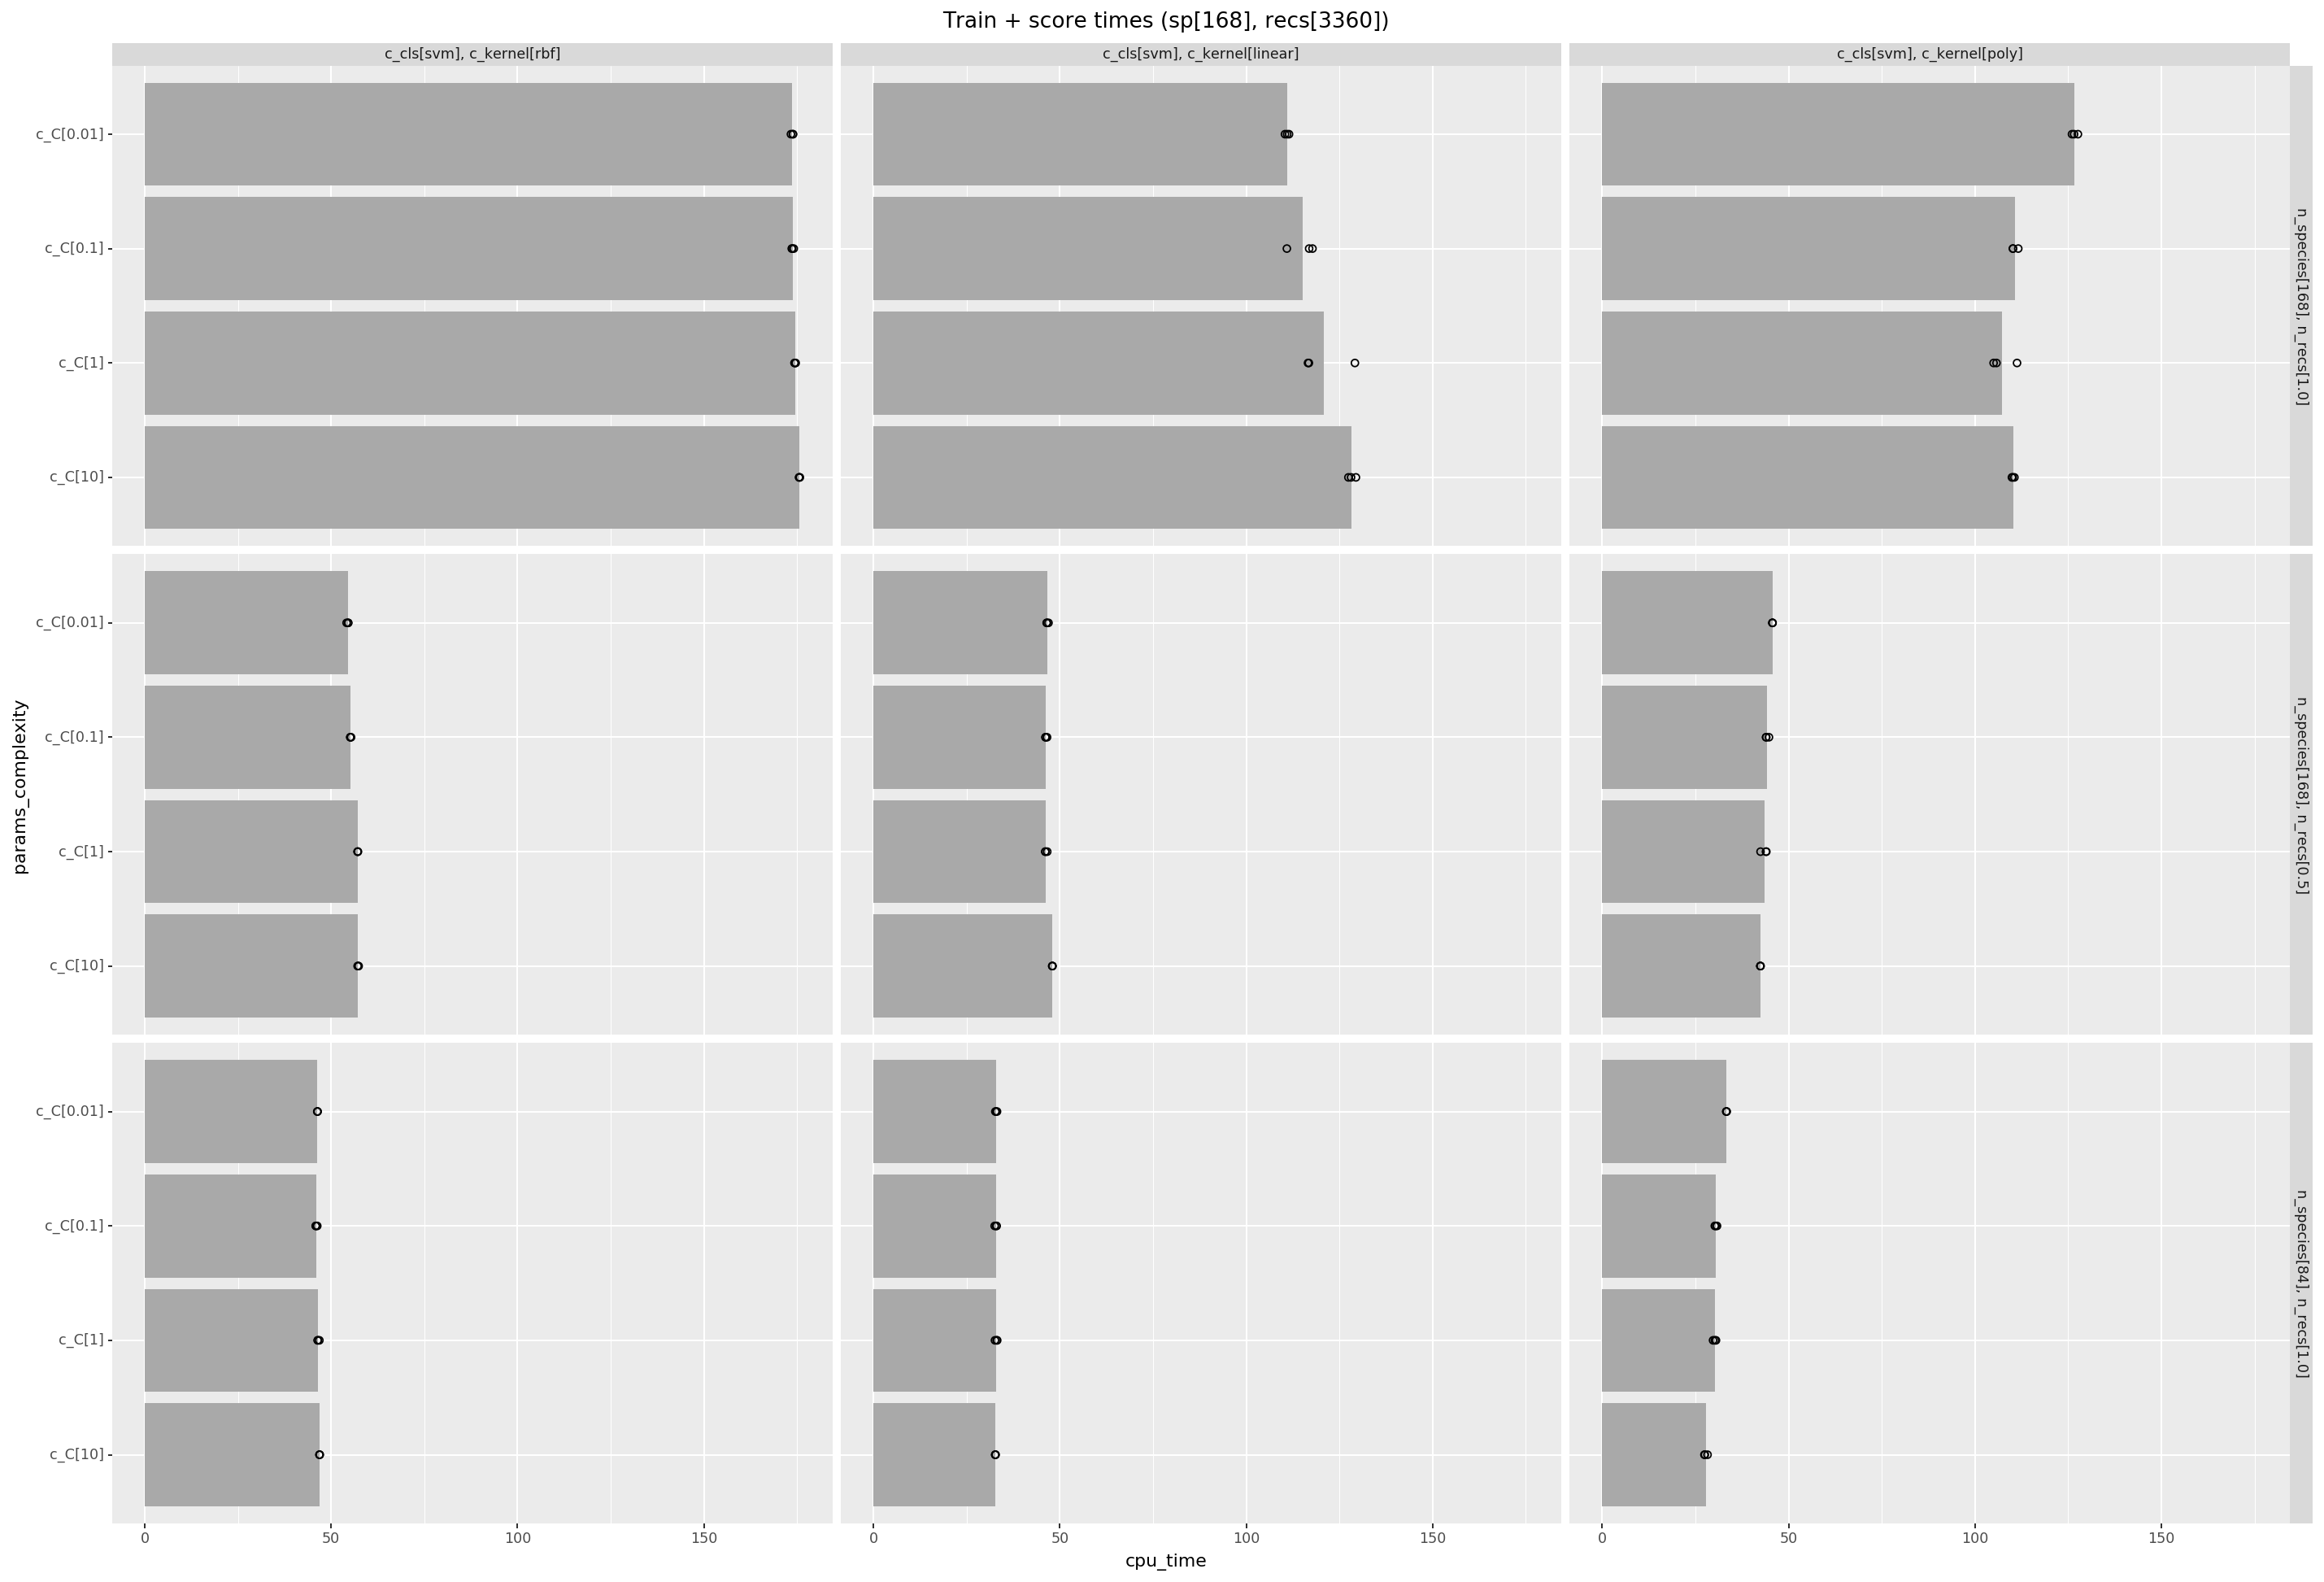

<ggplot: (319503834)>

In [ ]:
# TODO TODO Why are xgb train/score times bimodal?
#   - [x] Plot test_score ~ cpu_time -- anything informative here? [left panel!]
#   - [ ] Maybe the bimodal tree depths cause bimodal train/score times? -- plot the relationship
#       - But that'd be weird, since a gbm forest should avg out the individual tree depths...
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(cpu_total_mean=lambda df: df.cpu_time.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_col(aes(y='cpu_total_mean'), fill='darkgray', position=position_dodge())
    + geom_point(aes(y='cpu_time'), color='black', fill='none', size=2)
    + coord_flip()
    + ylab('cpu_time')
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle(f'Train + score times ({recs_stats})')
)

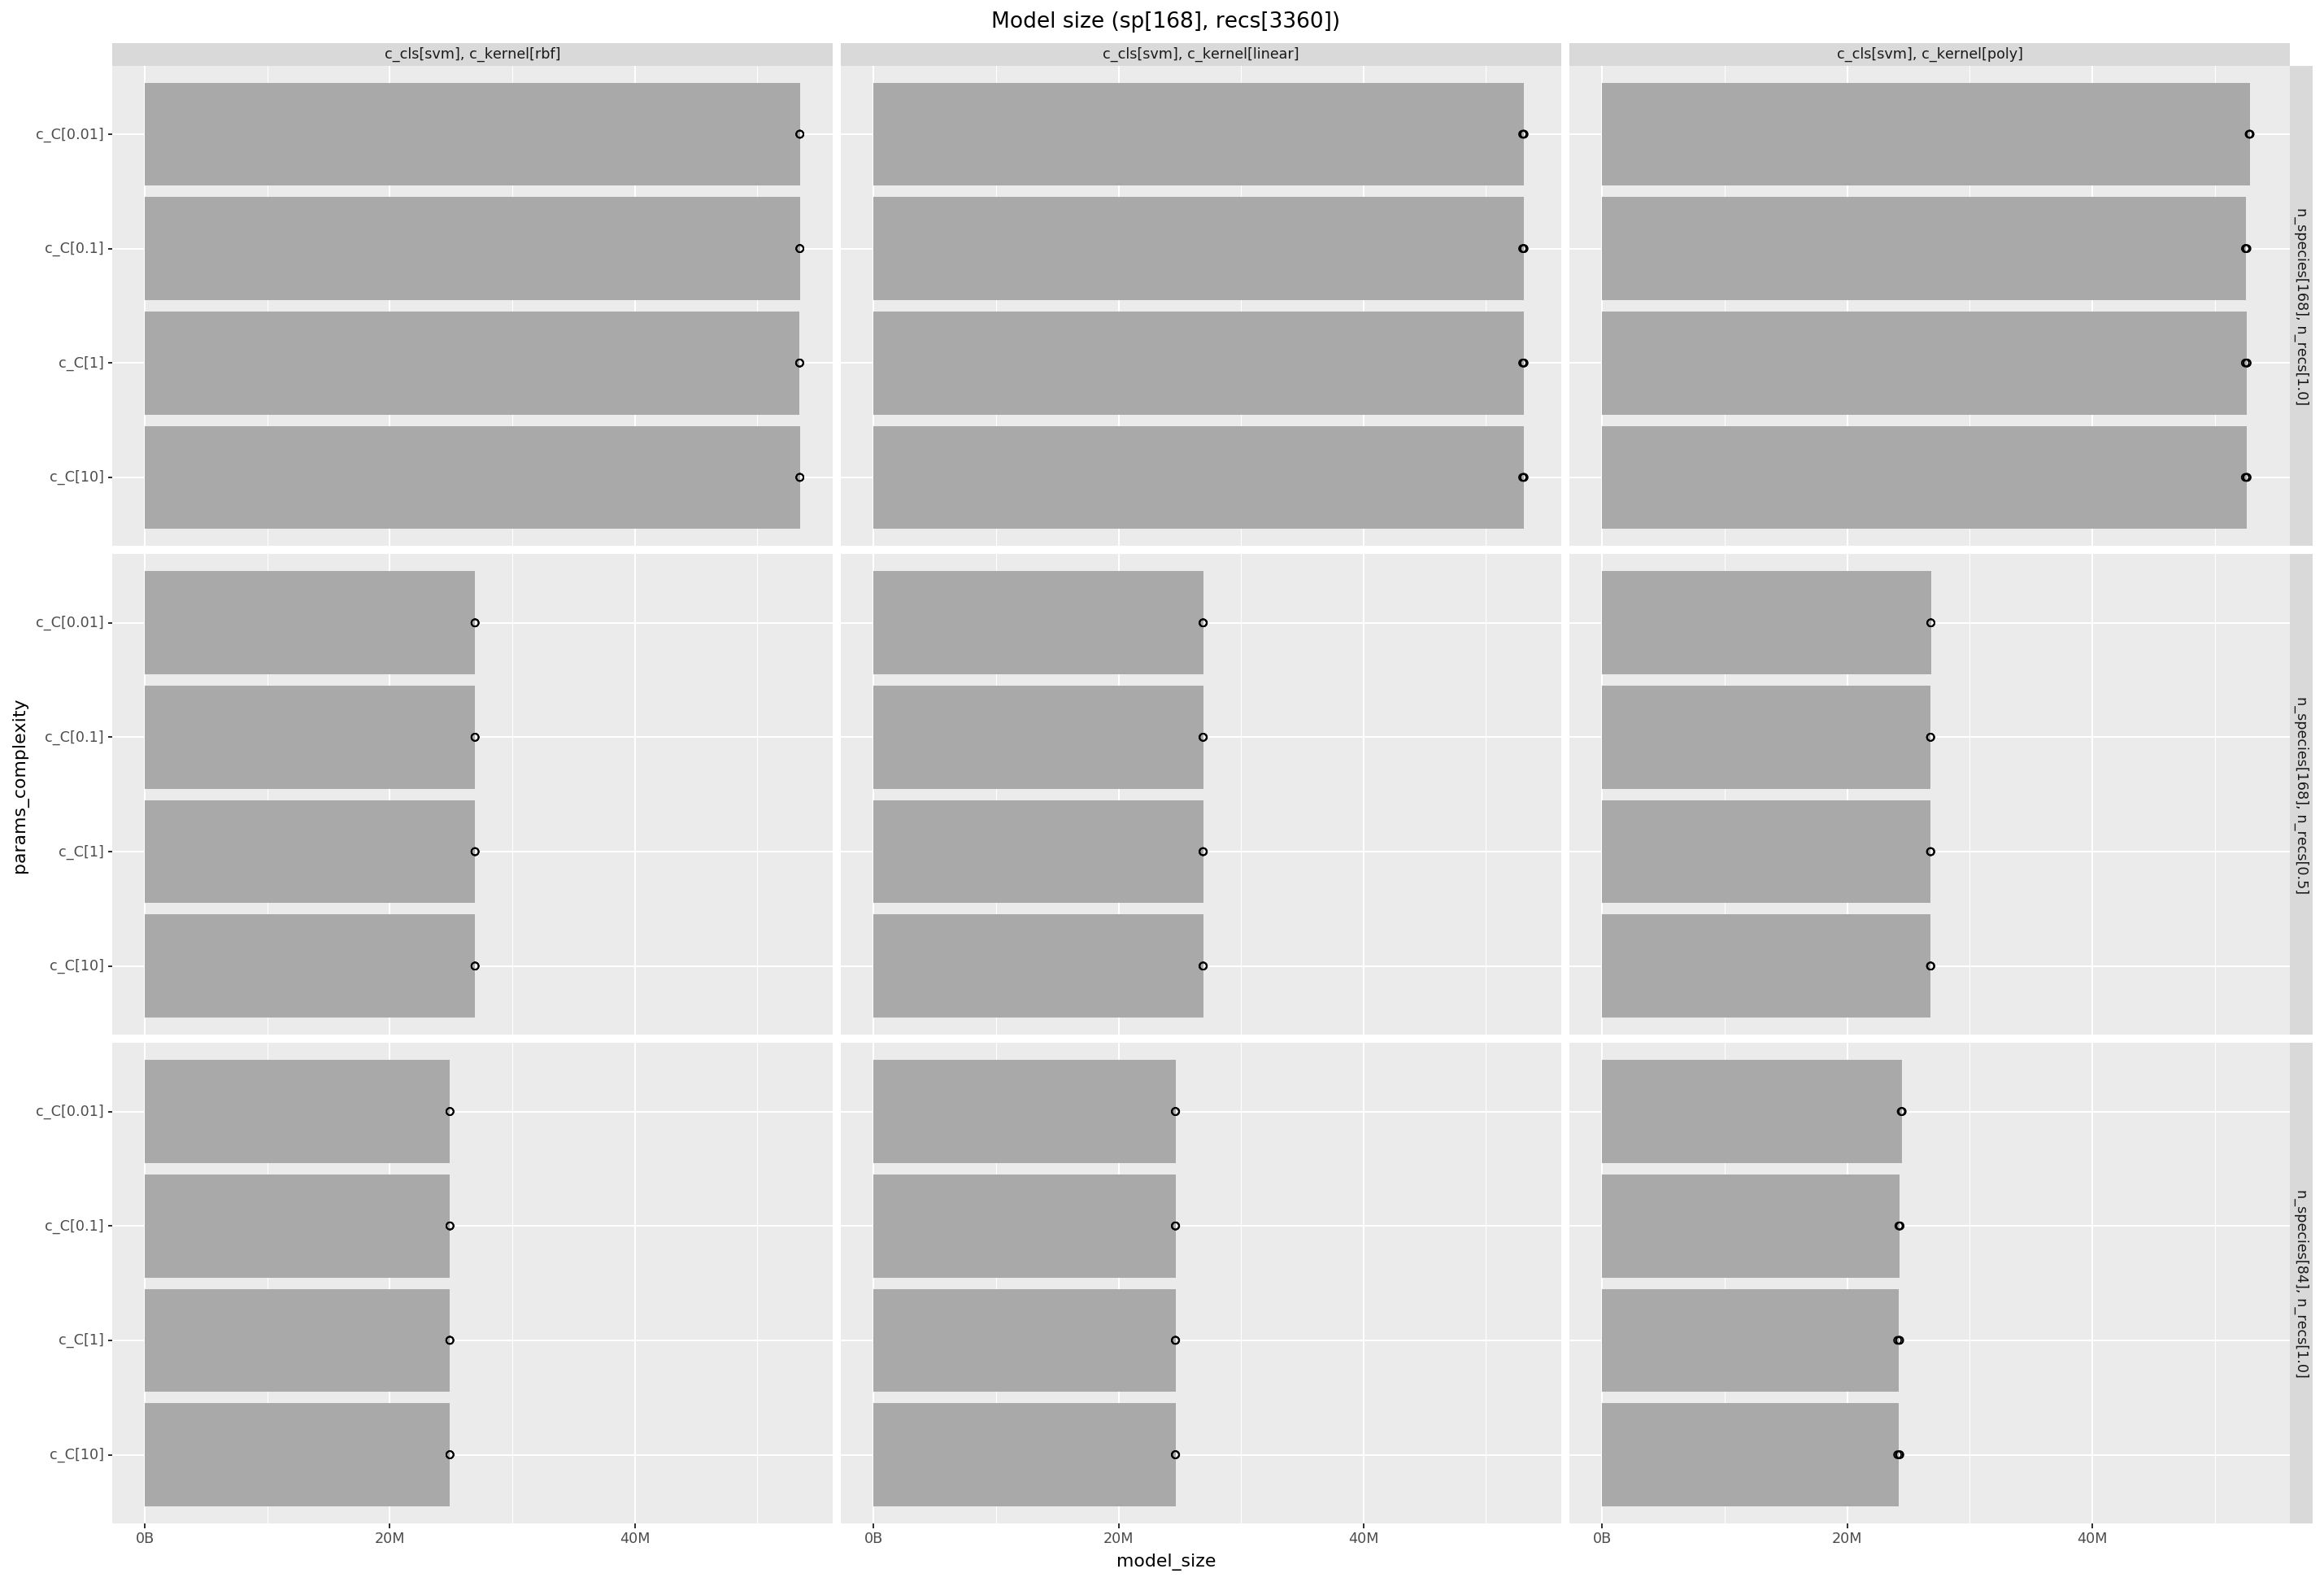

<ggplot: (-9223372036507331633)>

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(model_size_mean=lambda df: df.model_size.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_col(aes(y='model_size_mean'), fill='darkgray', position=position_dodge()) # Summary per fold
    + geom_point(aes(y='model_size'), color='black', fill='none', size=2) # Distribution of folds
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + coord_flip()
    + ylab('model_size')
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle(f'Model size ({recs_stats})')
)

In [ ]:
# Forest depth stats so we can tune max_depth, model_size
#   - TODO Generalize for models other than tree ensembles
cv_models = (cv_models
    .assign(
        forest_depth_mean=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.mean())),
        forest_depth_std=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.std())),
    )
)
display(
    # cv_models[['model_id', 'forest_depth_mean', 'forest_depth_std']][:5],
)

In [ ]:
# TODO TODO Make not barf on non-tree models (blocks rest of notebook)
(cv_models
    # Manually compute boxplot stats, else it's _really_ slow (or you have to downsample, which misses outliers)
    #   - Based on stat_boxplot.compute_group
    .merge(how='left', on='params', right=cv_models.groupby('params').apply(lambda g: one(
        pd.Series(dict(
            params=g.name,
            ymin=boxplot['whislo'],
            lower=boxplot['q1'],
            middle=boxplot['med'],
            upper=boxplot['q3'],
            ymax=boxplot['whishi'],
            outliers=np.unique(boxplot['fliers']),  # np.unique else really slow, because lots of repeated (int) points
        ))
        for [boxplot] in [mpl.cbook.boxplot_stats(  # [boxplot] is 1 elem because X.ndim = 1
            X=np.concatenate([[] if x is None else x.depth for x in g.model_stats]),
            whis=1.5,
        )]
    )))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_boxplot(
        stat='identity',
        outlier_size=.5,
        mapping=aes(ymin='ymin', ymax='ymax', upper='upper', lower='lower', middle='middle', outliers='outliers',
            width=.8,  # Close enough to geom_boxplot defaults [TODO Maybe should compute based on num categorical x's?]
        ),
    )
    + ylab('tree_depth')
    + coord_flip()
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle(f'Tree depth ({recs_stats})')

)

[skip]

In [ ]:
# XXX Revive if insightful
(cv_models
    .pipe(df_reverse_cat, 'params_no_ns')
    .assign(n_species=lambda df: df.params_dict.str['n_species'])
    .pipe(ggplot, aes(x='n_species', y='forest_depth_mean', color='params_no_ns'))
    # + facet_wrap('params_no_ns', ncol=2)
    + geom_point()
    + geom_pointrange(aes(ymin='forest_depth_mean - 2*forest_depth_std', ymax='forest_depth_mean + 2*forest_depth_std'))
    + geom_smooth(method='lm', se=False)  # Disable se because it only knows forest_depth_mean, no measure of spread
    + expand_limits(x=0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    # + theme_figsize(aspect_ratio=1/3)
    + theme_figsize(aspect_ratio=1/3)
    + ggtitle(f'RF depth vs. n_species ({recs_stats})')
)

[skip]

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(mem_rss_delta_mean=lambda df: df.mem_rss_delta.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='mem_rss_delta_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='mem_rss_delta'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Mem rss spread ($max-min$) ({recs_stats})')
)

[skip]

In [ ]:
# TODO Might need to stack/geom_area for overlapping runs
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='cpu_system'), linetype='dashed', size=.5)
    + geom_line(aes(y='cpu_system + cpu_user'), linetype='solid', size=.5)
    + expand_limits(y=0)
    + ylab('cpu')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=lambda labels: ['%.3g%%' % x for x in labels])
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('cpu over time (system + user)')
)

[skip]

In [ ]:
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='mem_rss'), linetype='solid', size=.5)
    + geom_line(aes(y='mem_vms'), linetype='dashed', size=.5)
    + expand_limits(y=0)
    + ylab('mem')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes(pow=3))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('Mem over time (rss, vms)')
)

[skip]

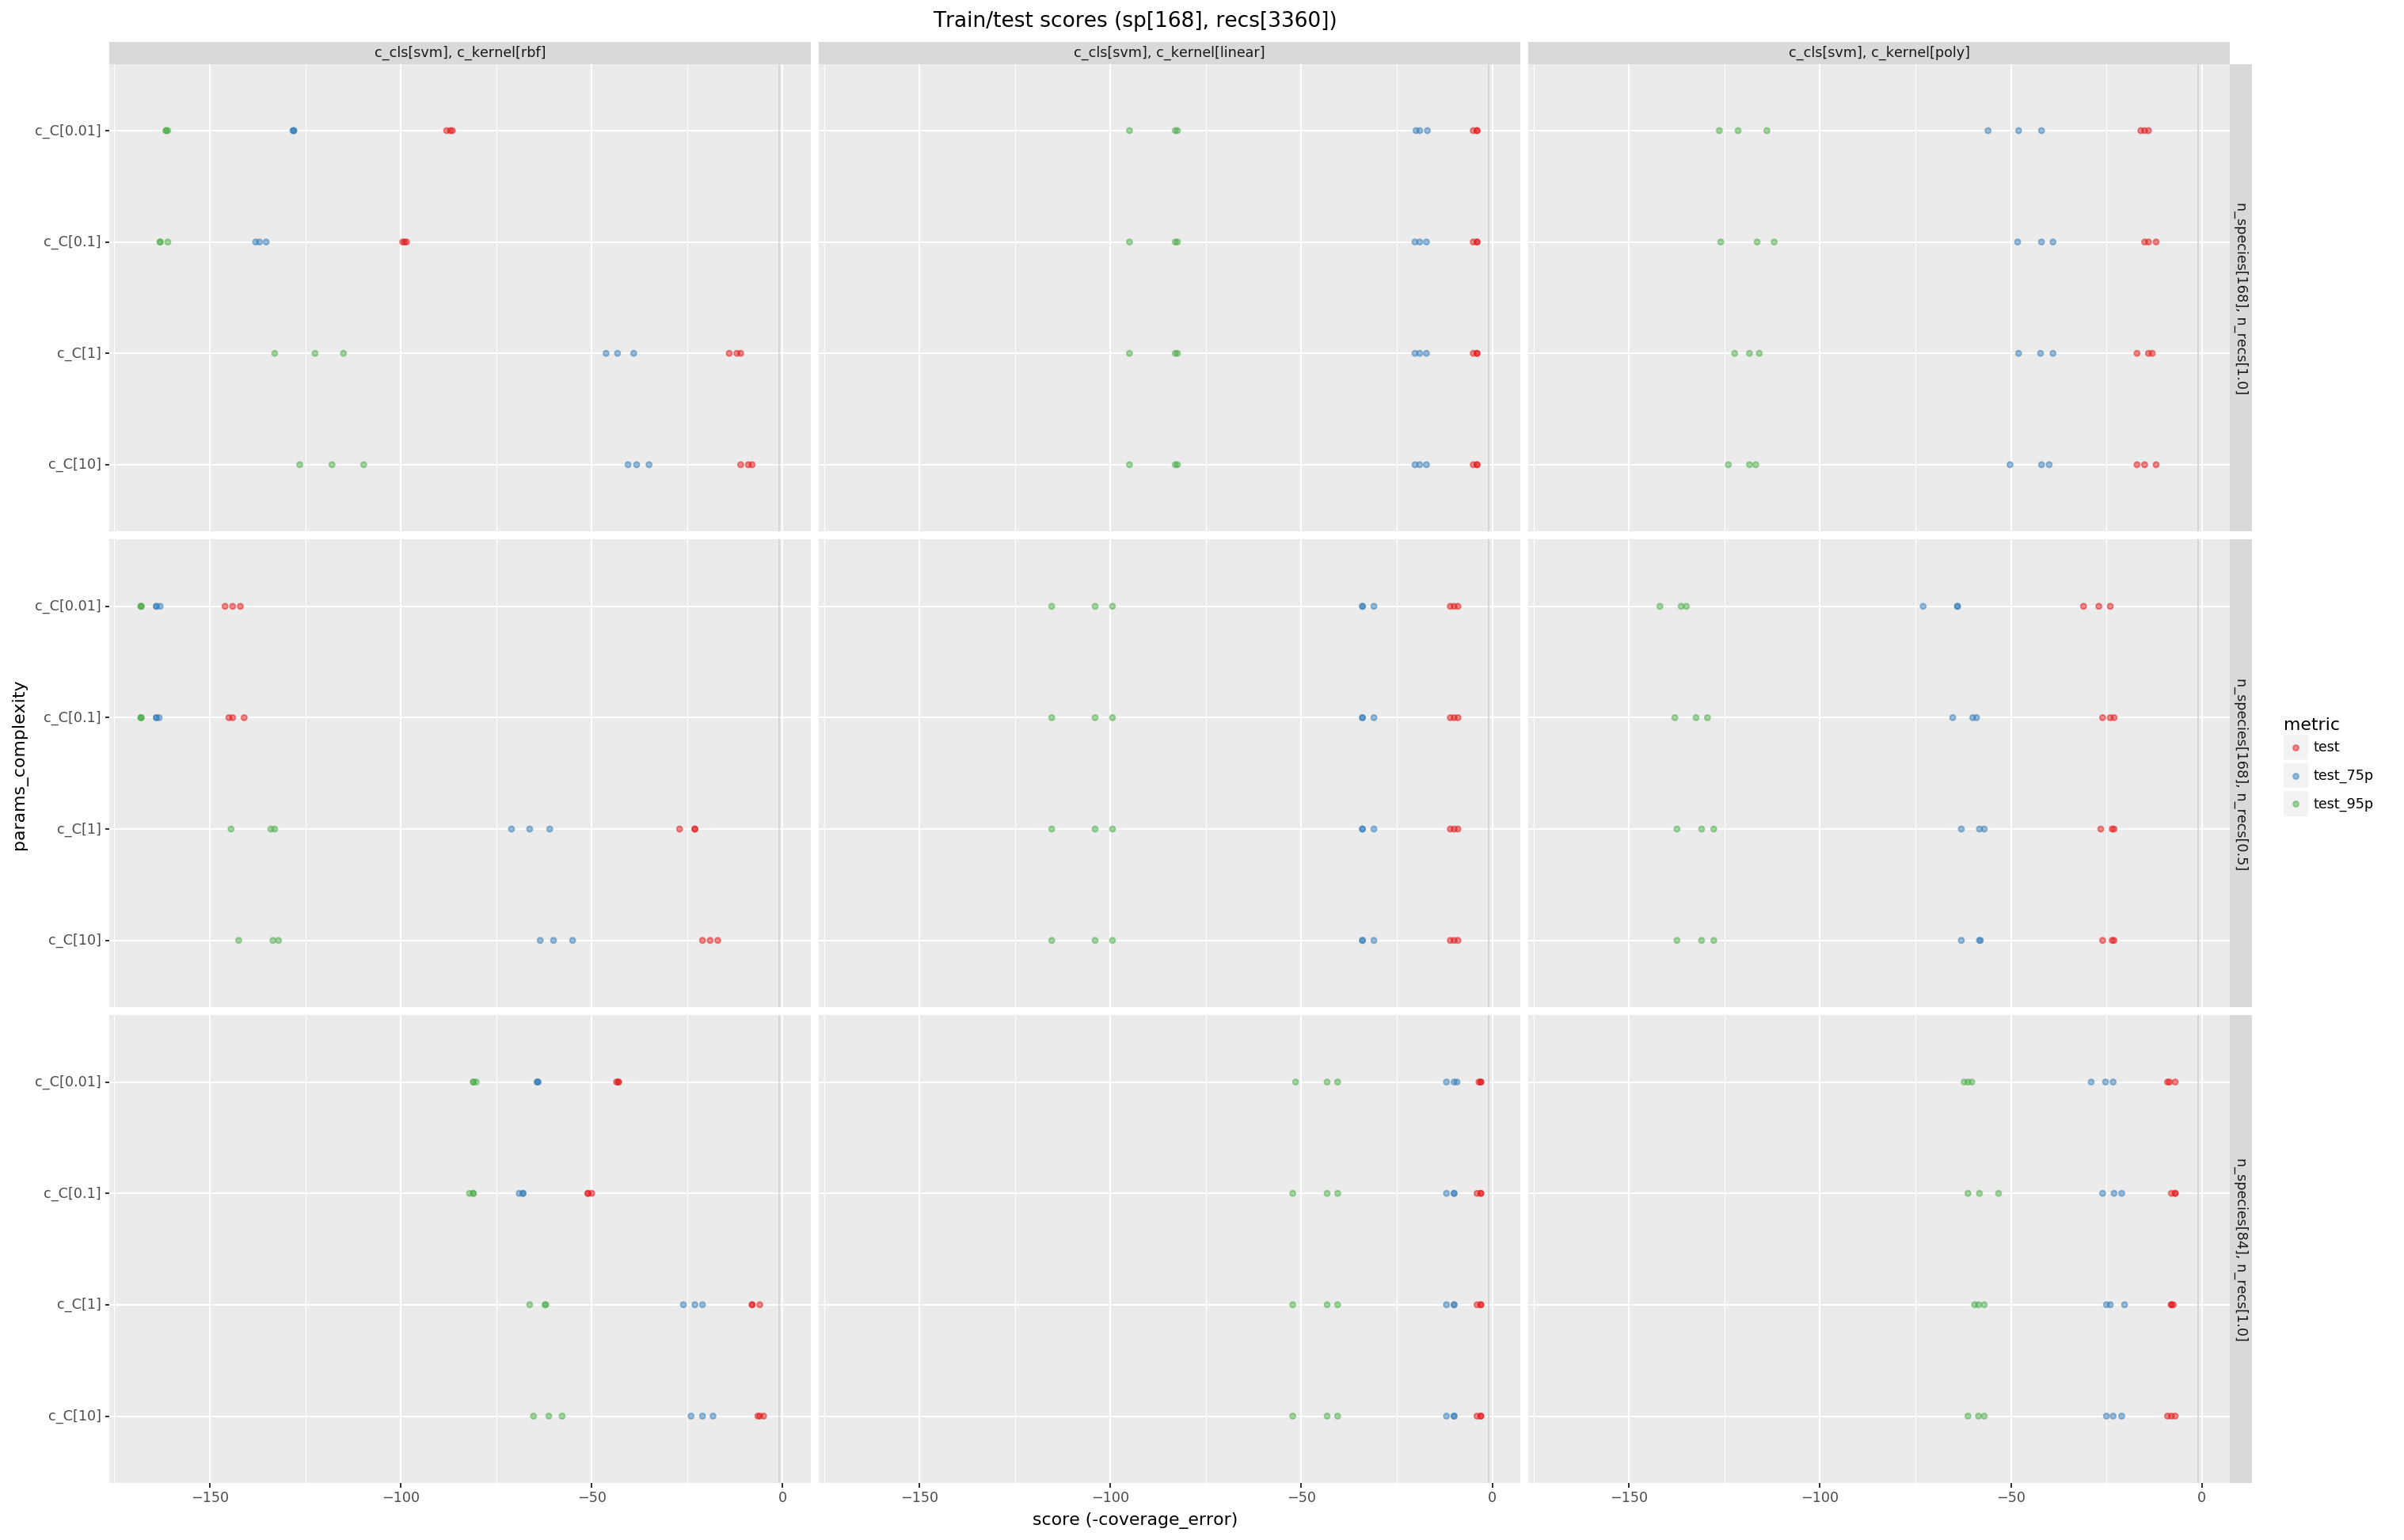

<ggplot: (389200918)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(lambda df: pd.melt(df,
        id_vars=['params_data', 'params_model', 'params_complexity', 'params', 'fold'],
        value_vars=[
            # 'train_score',  # Boring
            'test_score',
            'test_75p_score',
            'test_95p_score',
        ],
        var_name='metric',
        value_name='score'),
    )
    .assign(
        metric=lambda df: df.metric.str.replace('_score', ''),
        group=lambda df: df.params_complexity.str.cat(df.metric, '/'),
    )
    .pipe(df_ordered_cat,
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(ggplot)
    + aes(x='params_complexity')
    + aes(y='score')
    + aes(color='metric')
    + facet_grid('params_data ~ params_model')
    + geom_hline(yintercept=-1, color='lightgrey')  # -1 is the max score (1 is the min coverage_error)
    + geom_point(alpha=.5)
    # + geom_jitter(fill='none', size=3, height=1e-9, width=.05)
    # + geom_count(aes(size='..n..')) + scale_size_area()
    # + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + coord_flip(
        # ylim=(-30, 0),
    )
    # + scale_color_cmap_d('tab10')
    + scale_color_cmap_d('Set1')
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ylab('score (-coverage_error)')
    + ggtitle(f'Train/test scores ({recs_stats})')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 19 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


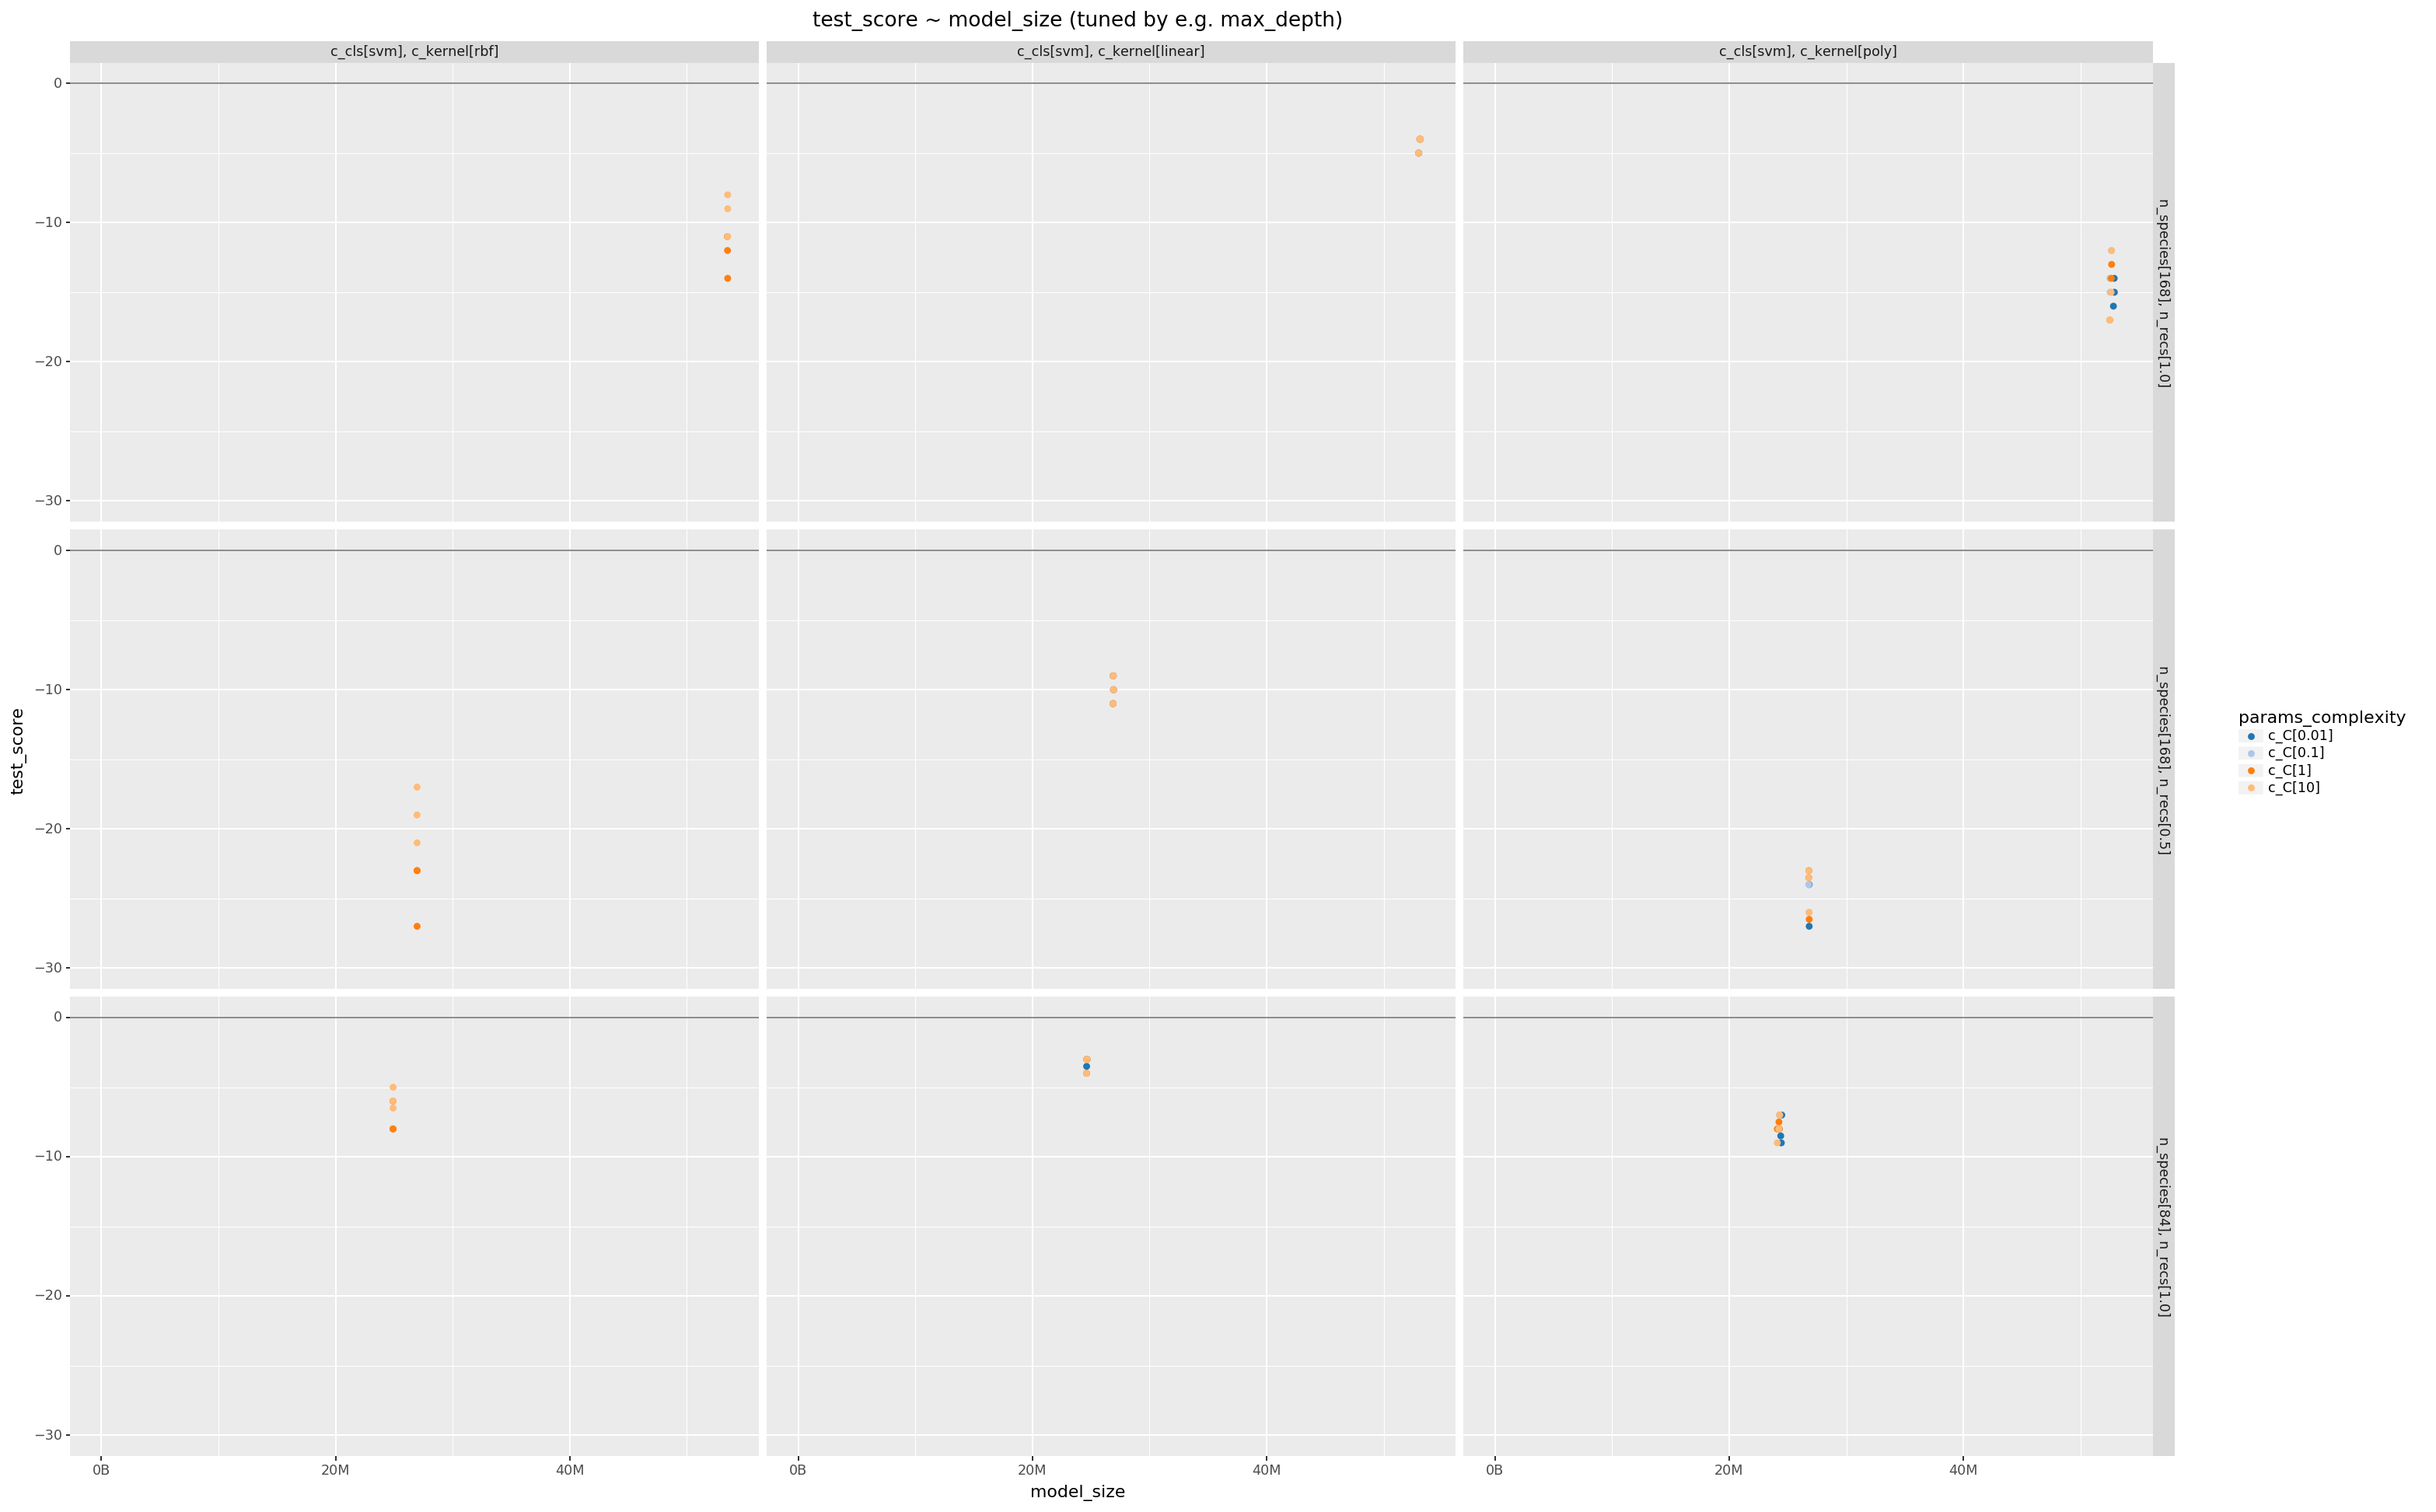

<ggplot: (316078179)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='model_size', y='test_score')
    + aes(color='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ model_size (tuned by e.g. max_depth)')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 19 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


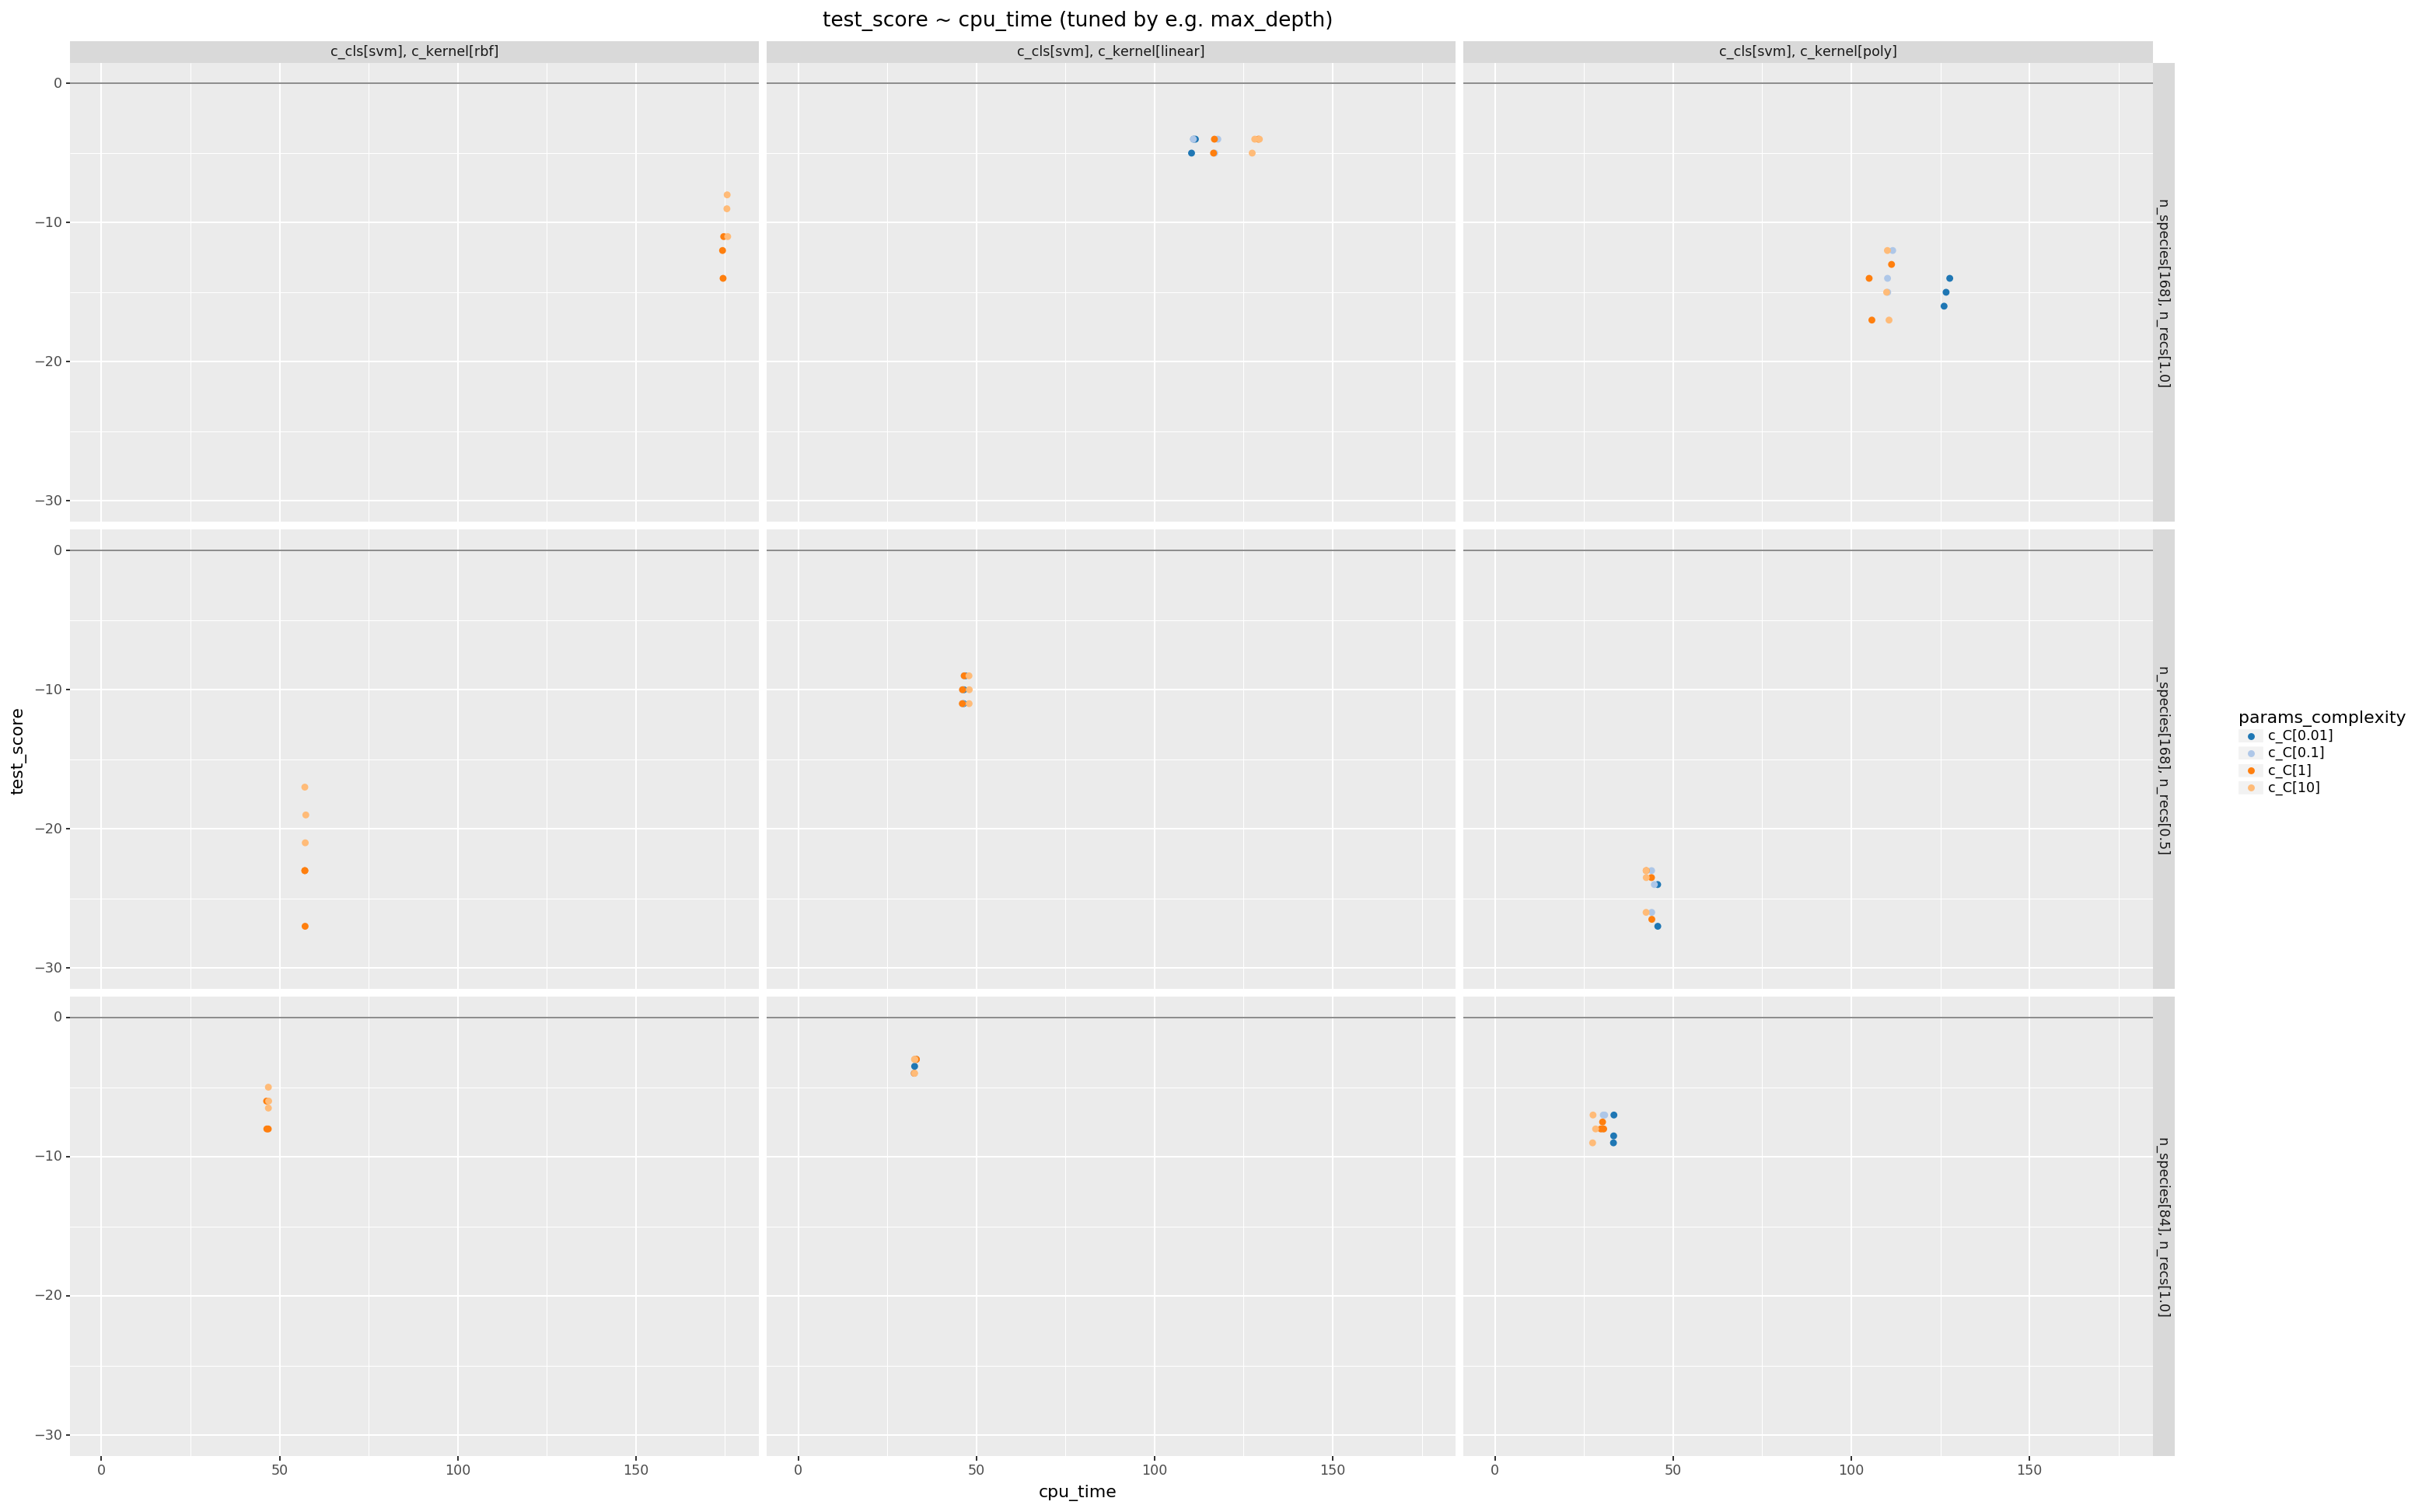

<ggplot: (-9223372036507331468)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='cpu_time', y='test_score')
    + aes(color='params_complexity')
    + facet_grid('params_data ~ params_model')
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    # + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=24, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ cpu_time (tuned by e.g. max_depth)')
)

In [ ]:
# SLOW_PLOTS_NEXT

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(cv_models.params.cat.categories))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/36]
  fold[*/3]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            params_data=row.params_data,
            params_model=row.params_model,
            params_complexity=row.params_complexity,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
    .astype(dict(
        model_id=cv_models.model_id.dtype,
        params=cv_models.params.dtype,
        params_data=cv_models.params_data.dtype,
        params_model=cv_models.params_model.dtype,
        params_complexity=cv_models.params_complexity.dtype,
    ))
    .pipe(tap, lambda df: display(
        df_summary(df).T,
        df[:10],
        df.params_data.value_counts(),
        df.params_model.value_counts(),
        df.params_complexity.value_counts(),
    ))
)

  0%|                                                                                          | 0/108 [00:00<?, ?it/s]

  3%|██▎                                                                               | 3/108 [00:00<00:05, 20.51it/s]

  6%|████▌                                                                             | 6/108 [00:00<00:04, 20.61it/s]

  8%|██████▊                                                                           | 9/108 [00:00<00:04, 20.75it/s]

 11%|█████████                                                                        | 12/108 [00:00<00:04, 20.76it/s]

 13%|██████████▌                                                                      | 14/108 [00:00<00:04, 20.54it/s]

 16%|████████████▊                                                                    | 17/108 [00:00<00:04, 20.63it/s]

 19%|███████████████                                                                  | 20/108 [00:00<00:04, 20.61it/s]

 21%|█████████████████▎                                                               | 23/108 [00:01<00:04, 20.66it/s]

 24%|███████████████████▌                                                             | 26/108 [00:01<00:03, 20.68it/s]

 27%|█████████████████████▊                                                           | 29/108 [00:01<00:03, 20.67it/s]

 30%|████████████████████████                                                         | 32/108 [00:01<00:03, 20.66it/s]

 32%|██████████████████████████▎                                                      | 35/108 [00:01<00:03, 20.68it/s]

 35%|████████████████████████████▌                                                    | 38/108 [00:01<00:03, 20.71it/s]

 38%|██████████████████████████████▊                                                  | 41/108 [00:01<00:03, 20.66it/s]

 41%|█████████████████████████████████                                                | 44/108 [00:02<00:03, 20.68it/s]

 44%|███████████████████████████████████▎                                             | 47/108 [00:02<00:02, 20.67it/s]

 46%|█████████████████████████████████████▌                                           | 50/108 [00:02<00:02, 20.69it/s]

 49%|███████████████████████████████████████▊                                         | 53/108 [00:02<00:02, 20.66it/s]

 52%|██████████████████████████████████████████                                       | 56/108 [00:02<00:02, 20.66it/s]

 55%|████████████████████████████████████████████▎                                    | 59/108 [00:02<00:02, 20.69it/s]

 57%|██████████████████████████████████████████████▌                                  | 62/108 [00:02<00:02, 20.72it/s]

 60%|████████████████████████████████████████████████▊                                | 65/108 [00:03<00:02, 20.52it/s]

 62%|██████████████████████████████████████████████████▎                              | 67/108 [00:03<00:01, 20.51it/s]

 64%|███████████████████████████████████████████████████▋                             | 69/108 [00:03<00:01, 20.43it/s]

 67%|██████████████████████████████████████████████████████                           | 72/108 [00:03<00:01, 20.43it/s]

 70%|█████████████████████████████████████████████████████████                        | 76/108 [00:03<00:01, 20.97it/s]

 74%|████████████████████████████████████████████████████████████                     | 80/108 [00:03<00:01, 21.45it/s]

 78%|███████████████████████████████████████████████████████████████                  | 84/108 [00:03<00:01, 21.93it/s]

 82%|██████████████████████████████████████████████████████████████████▊              | 89/108 [00:03<00:00, 22.54it/s]

 86%|█████████████████████████████████████████████████████████████████████▊           | 93/108 [00:04<00:00, 22.95it/s]

 91%|█████████████████████████████████████████████████████████████████████████▌       | 98/108 [00:04<00:00, 23.49it/s]

 95%|████████████████████████████████████████████████████████████████████████████▎   | 103/108 [00:04<00:00, 24.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 24.51it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,category,7416864,60480,60480,108,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[linear], c_C[10], fold[1]","n_species[168], n_recs[0.5], c_cls[svm], c_kernel[rbf], c_C[1], fold[2]","n_species[168], n_recs[0.5], c_cls[svm], c_kernel[poly], c_C[1], fold[1]","n_species[84], n_recs[1.0], c_cls[svm], c_kernel[poly], c_C[10], fold[2]"
params,category,6872544,60480,60480,36,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[linear], c_C[10]","n_species[168], n_recs[0.5], c_cls[svm], c_kernel[rbf], c_C[1]","n_species[168], n_recs[0.5], c_cls[svm], c_kernel[poly], c_C[1]","n_species[84], n_recs[1.0], c_cls[svm], c_kernel[poly], c_C[10]"
params_data,category,11309760,60480,60480,3,NaN,NaN,"n_species[168], n_recs[1.0]","n_species[168], n_recs[1.0]","n_species[168], n_recs[0.5]","n_species[168], n_recs[0.5]","n_species[84], n_recs[1.0]"
params_model,category,11168640,60480,60480,3,NaN,NaN,"c_cls[svm], c_kernel[rbf]","c_cls[svm], c_kernel[rbf]","c_cls[svm], c_kernel[linear]","c_cls[svm], c_kernel[poly]","c_cls[svm], c_kernel[poly]"
params_complexity,category,5473440,60480,60480,4,NaN,NaN,c_C[0.01],c_C[0.01],c_C[0.1],c_C[1],c_C[10]
fold,int64,1612800,60480,60480,3,1.000,0.817,0,0,1,2,2
i,int64,1693152,60480,60480,1638,1677.621,969.897,0,837,1678,2512,3356
y_true,object,5140800,60480,60480,168,NaN,NaN,ACWO,CORA,LBWO,RNGR,YRWA
coverage_error,float64,1451520,60480,60480,168,37.945,46.709,1,3,16,57,168


,model_id,params,params_data,params_model,params_complexity,fold,i,y_true,coverage_error
0,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,1765,CASJ,35.0
1,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,1551,VEFL,149.0
2,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,2967,LISP,95.0
3,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,578,LBCU,88.0
4,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,684,BOGU,21.0
5,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,1209,BTAH,22.0
6,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,2372,BETH,15.0
7,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,2874,WCSP,152.0
8,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,1424,LEFL,88.0
9,"n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01], fold[0]","n_species[168], n_recs[1.0], c_cls[svm], c_kernel[rbf], c_C[0.01]","n_species[168], n_recs[1.0]","c_cls[svm], c_kernel[rbf]",c_C[0.01],0,2115,BEWR,14.0


n_species[168], n_recs[0.5]    24192
n_species[168], n_recs[1.0]    24192
n_species[84], n_recs[1.0]     12096
Name: params_data, dtype: int64

c_cls[svm], c_kernel[poly]      20160
c_cls[svm], c_kernel[linear]    20160
c_cls[svm], c_kernel[rbf]       20160
Name: params_model, dtype: int64

c_C[10]      15120
c_C[1]       15120
c_C[0.1]     15120
c_C[0.01]    15120
Name: params_complexity, dtype: int64

In [ ]:
params_data = 'n_species[168], n_recs[1.0]'
n_species = parse.search('n_species[{n_species:d}], n_recs[{n_recs:f}]', params_data)['n_species']

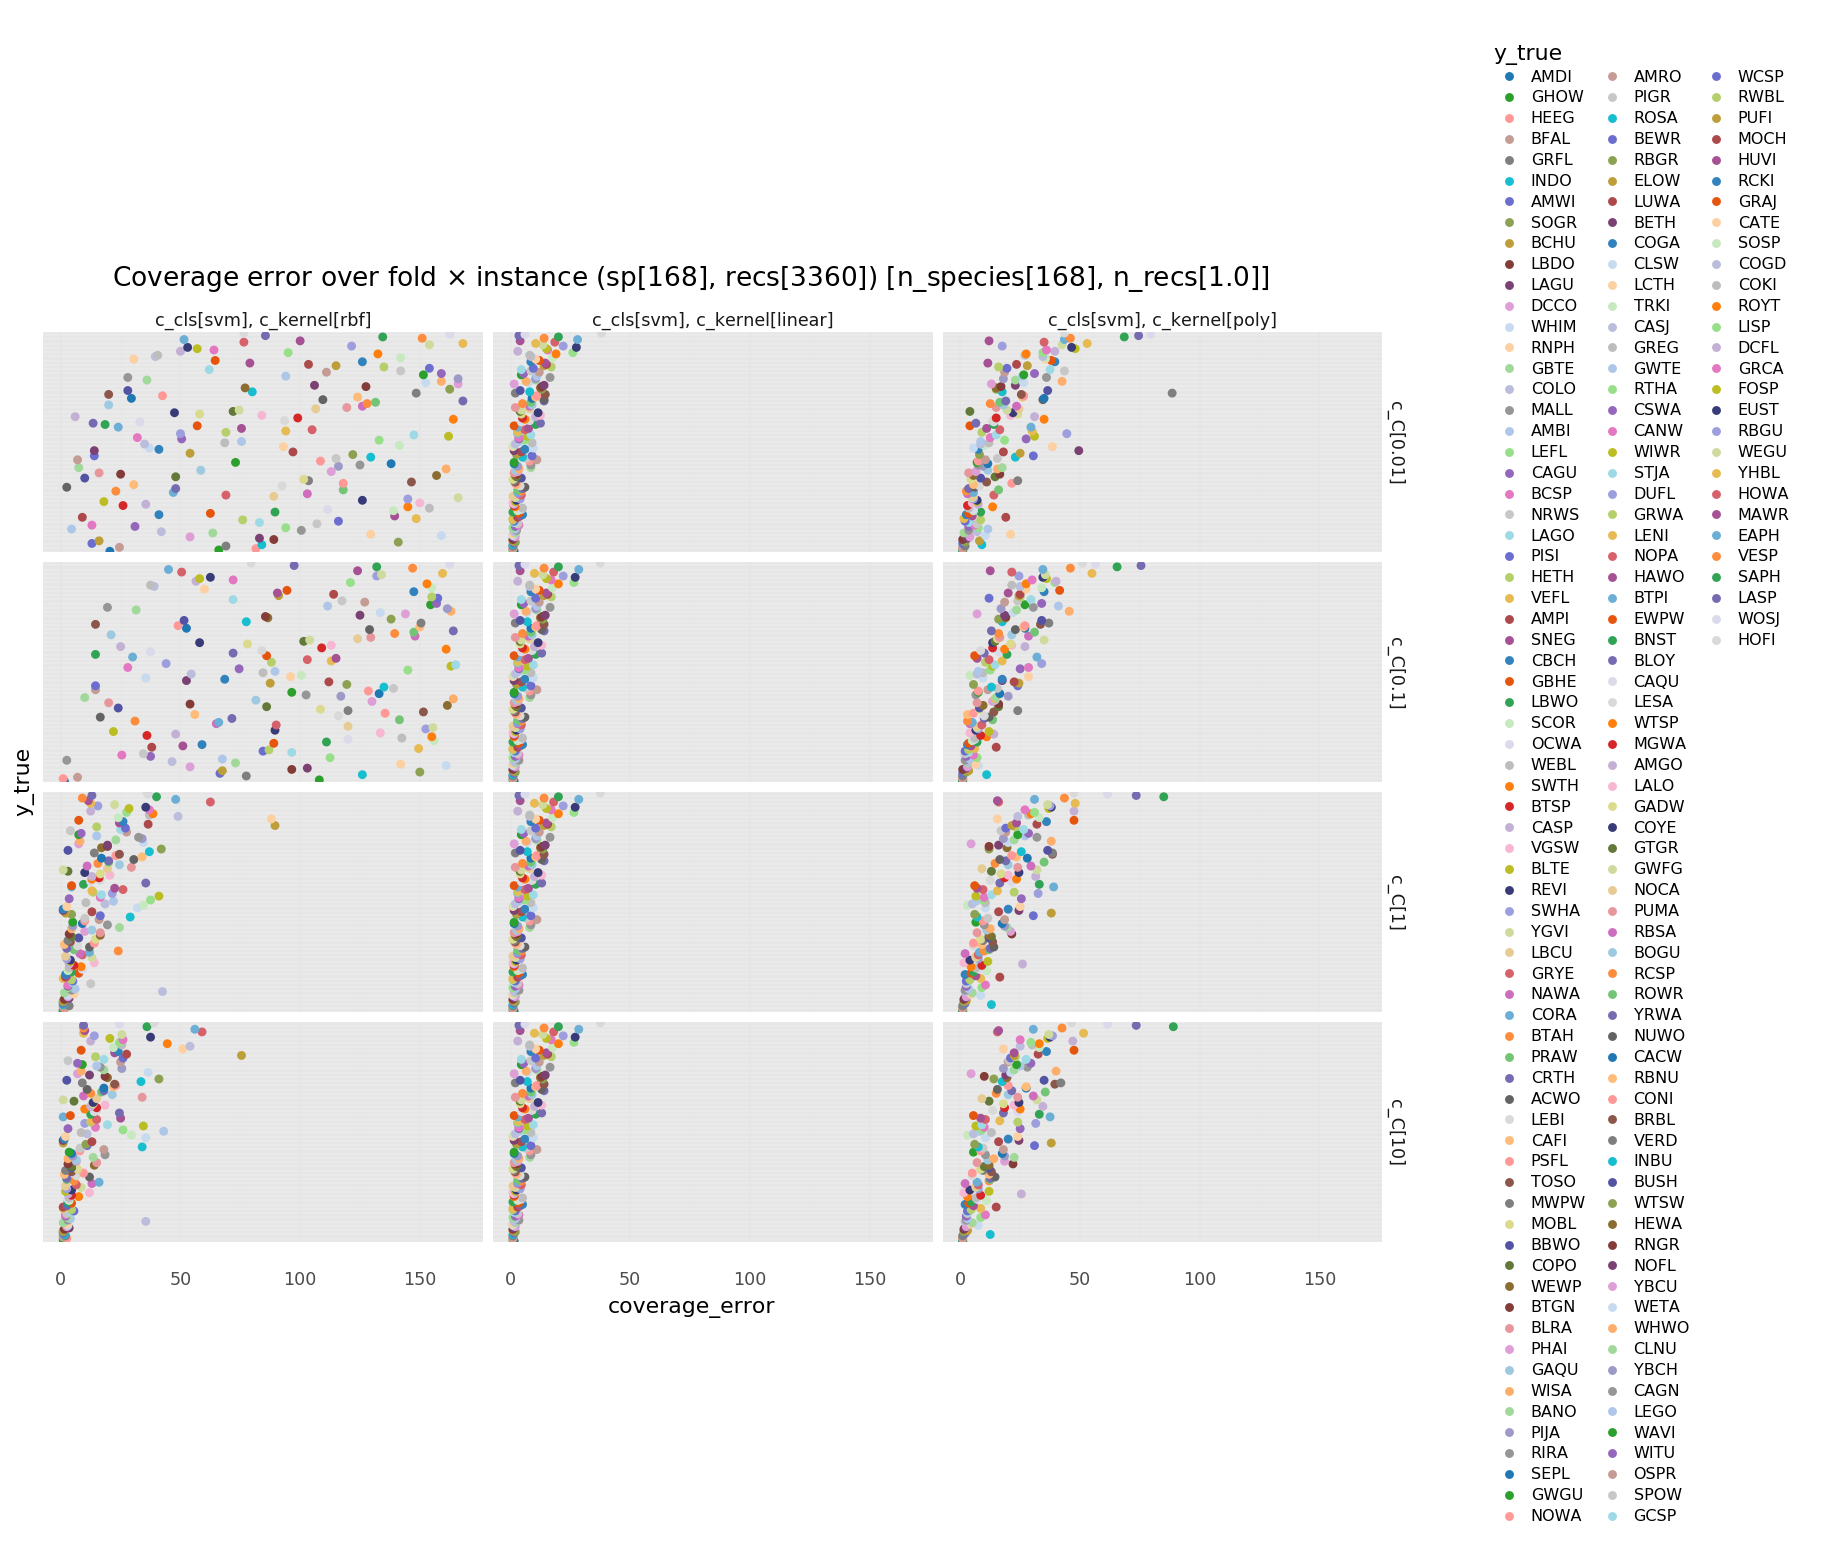

<ggplot: (385841002)>

In [ ]:
# Facet by params_no_ns, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    # .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
    )
    .pipe(ggplot)
    + aes(x='y_true', y='coverage_error')
    + aes(color='y_true')
    + facet_grid('params_complexity ~ params_model')
    # + geom_line(aes(group='params'), stat='summary', fun_y=np.median)  # TODO Bad interpolation with n_species
    + geom_point(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + theme_minimal()  # Before other theme()
    + guides(color=guide_legend(nrow=70))
    + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8, legend_text=element_text(size=8))
    + theme(axis_text_y=element_blank())
    + theme_figsize(width=12, aspect_ratio=1/2)
    + ggtitle(rf'Coverage error over fold $\times$ instance ({recs_stats}) [{params_data}]')
)

(60480, 9)
(24192, 9)
(8064, 9)


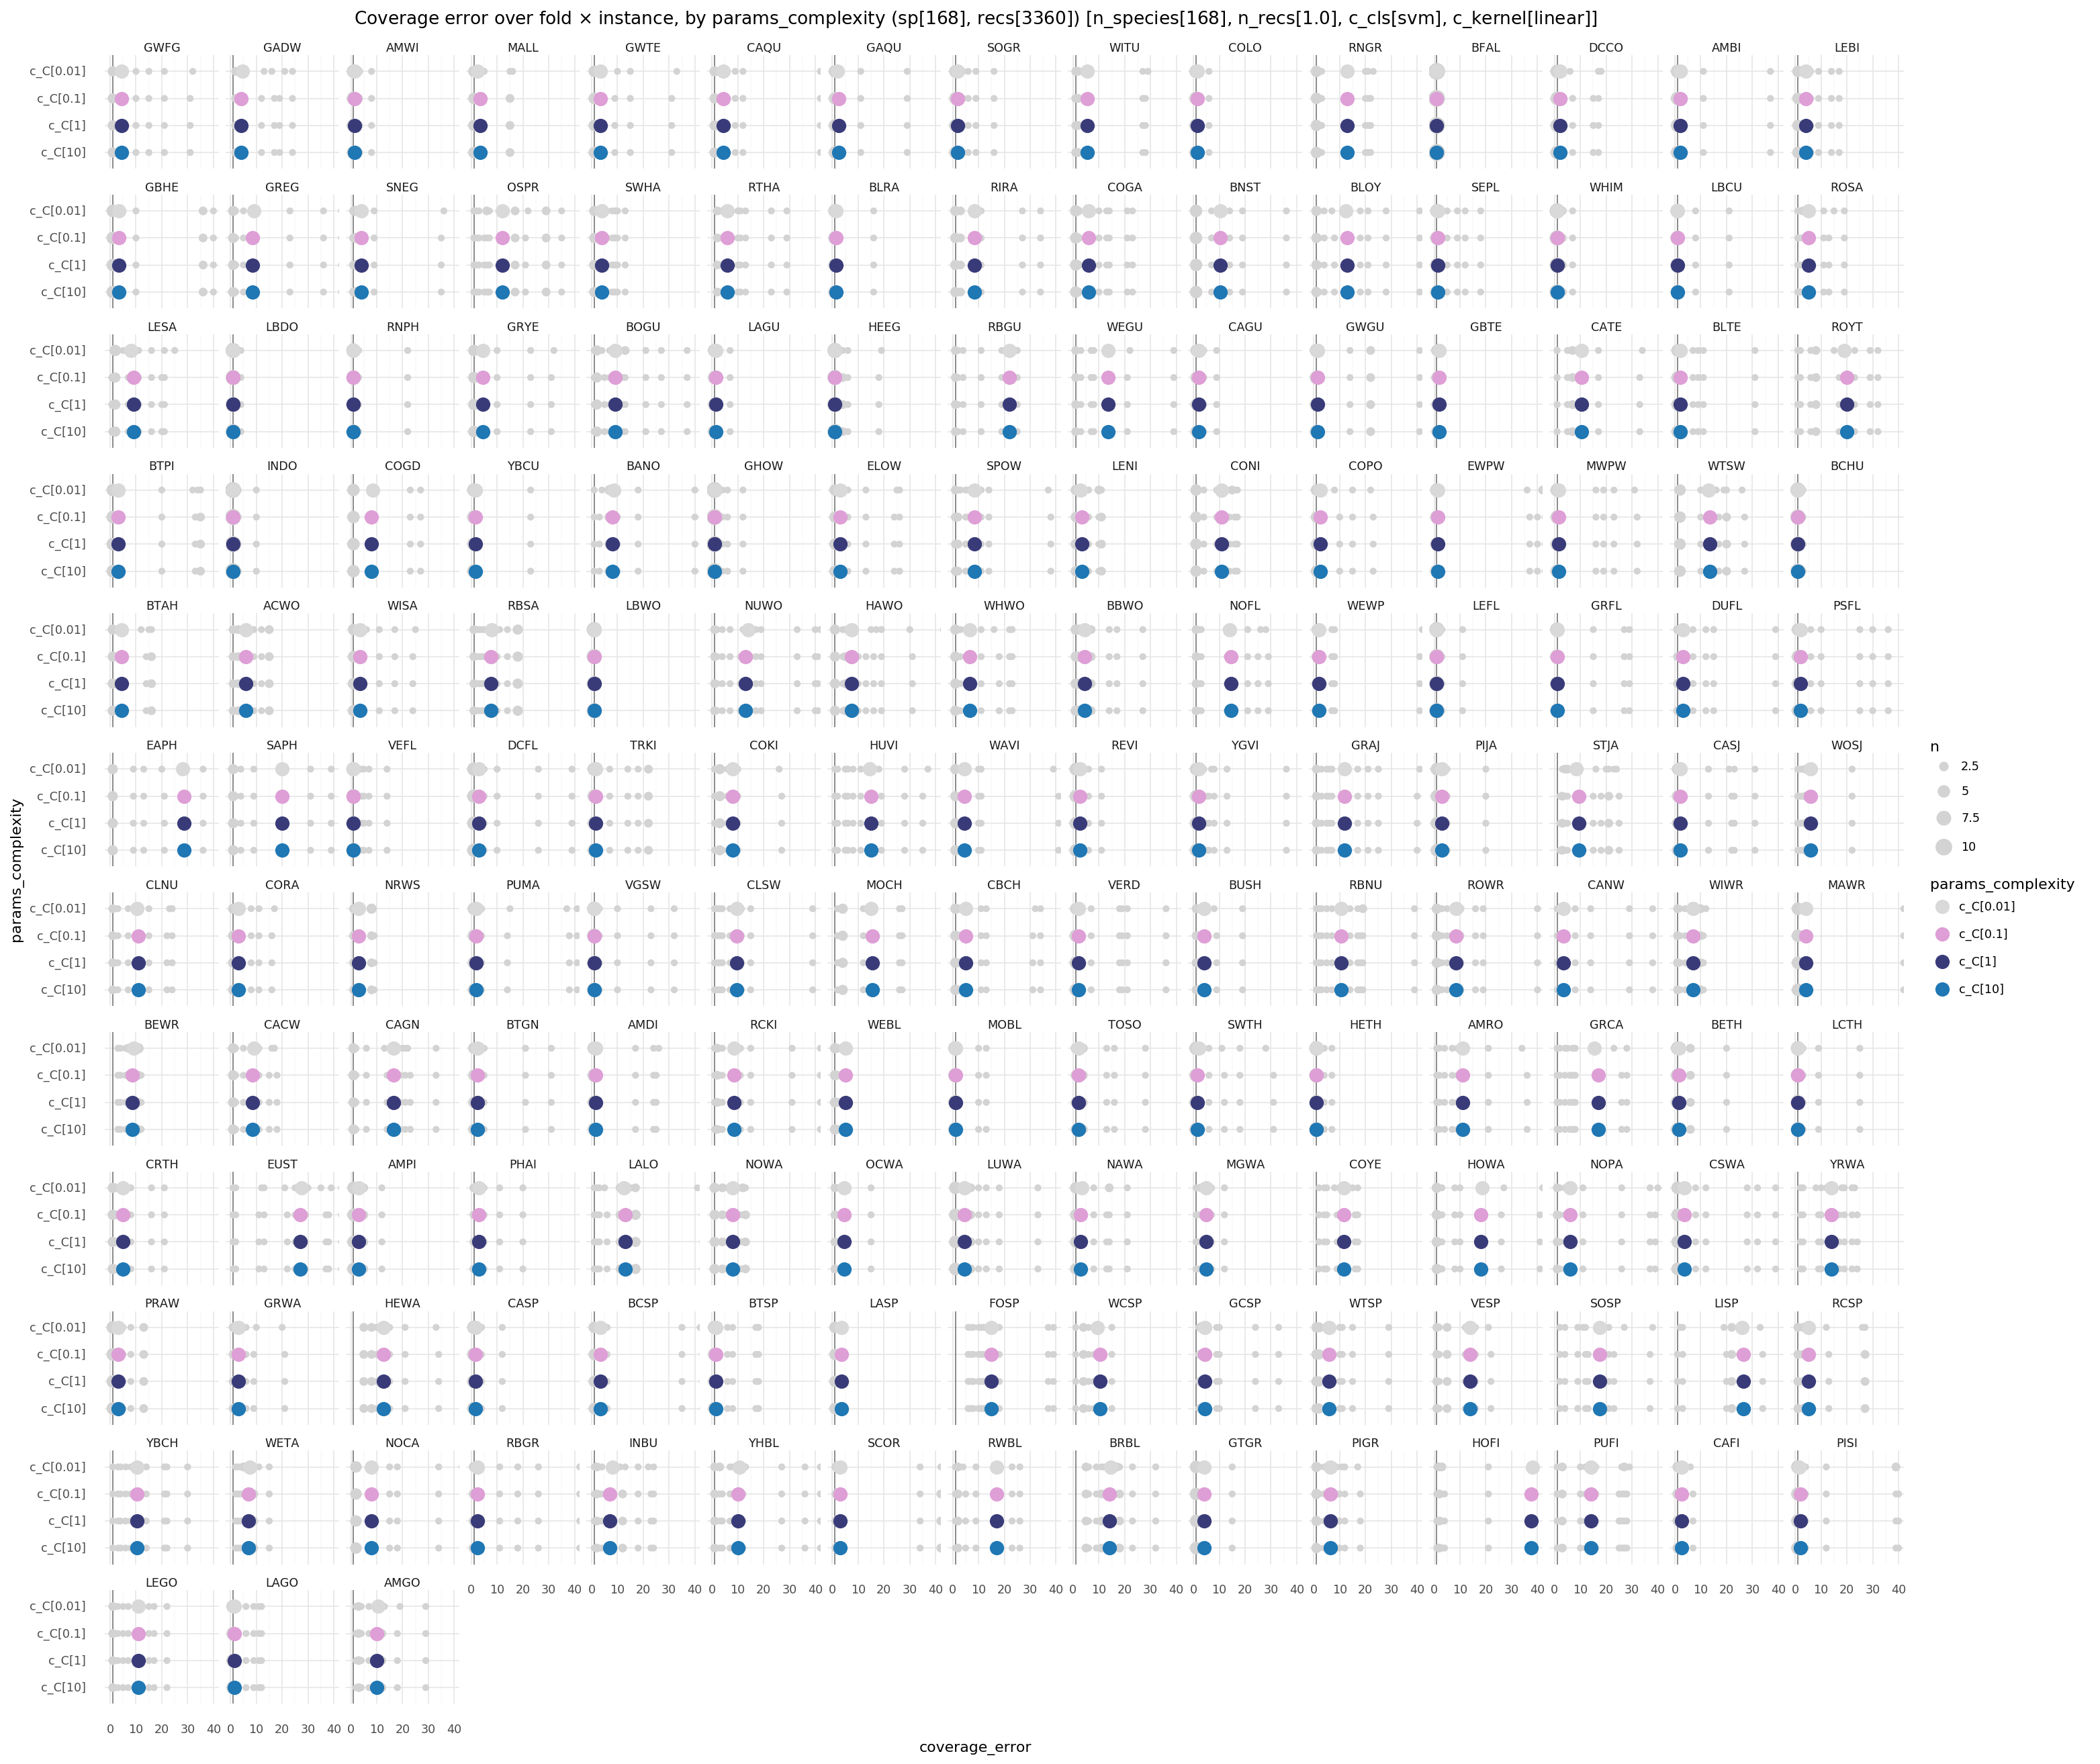

<ggplot: (380109681)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
# params_model = 'c_cls[rf], c_n_estimators[100]'
# params_model = 'c_cls[logreg_multi], c_solver[newton-cg]'
params_model = 'c_cls[svm], c_kernel[linear]'
(coverage_errors_all_all
    .pipe(puts, lambda df: df.shape)
    [lambda df: df.params_data == params_data]
    .pipe(puts, lambda df: df.shape)
    [lambda df: df.params_model == params_model]
    .pipe(puts, lambda df: df.shape)
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity', y='coverage_error')
    + aes(color='params_complexity')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    # + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab10'))  # Strong
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=24, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_complexity ({recs_stats}) [{params_data}, {params_model}]')
)

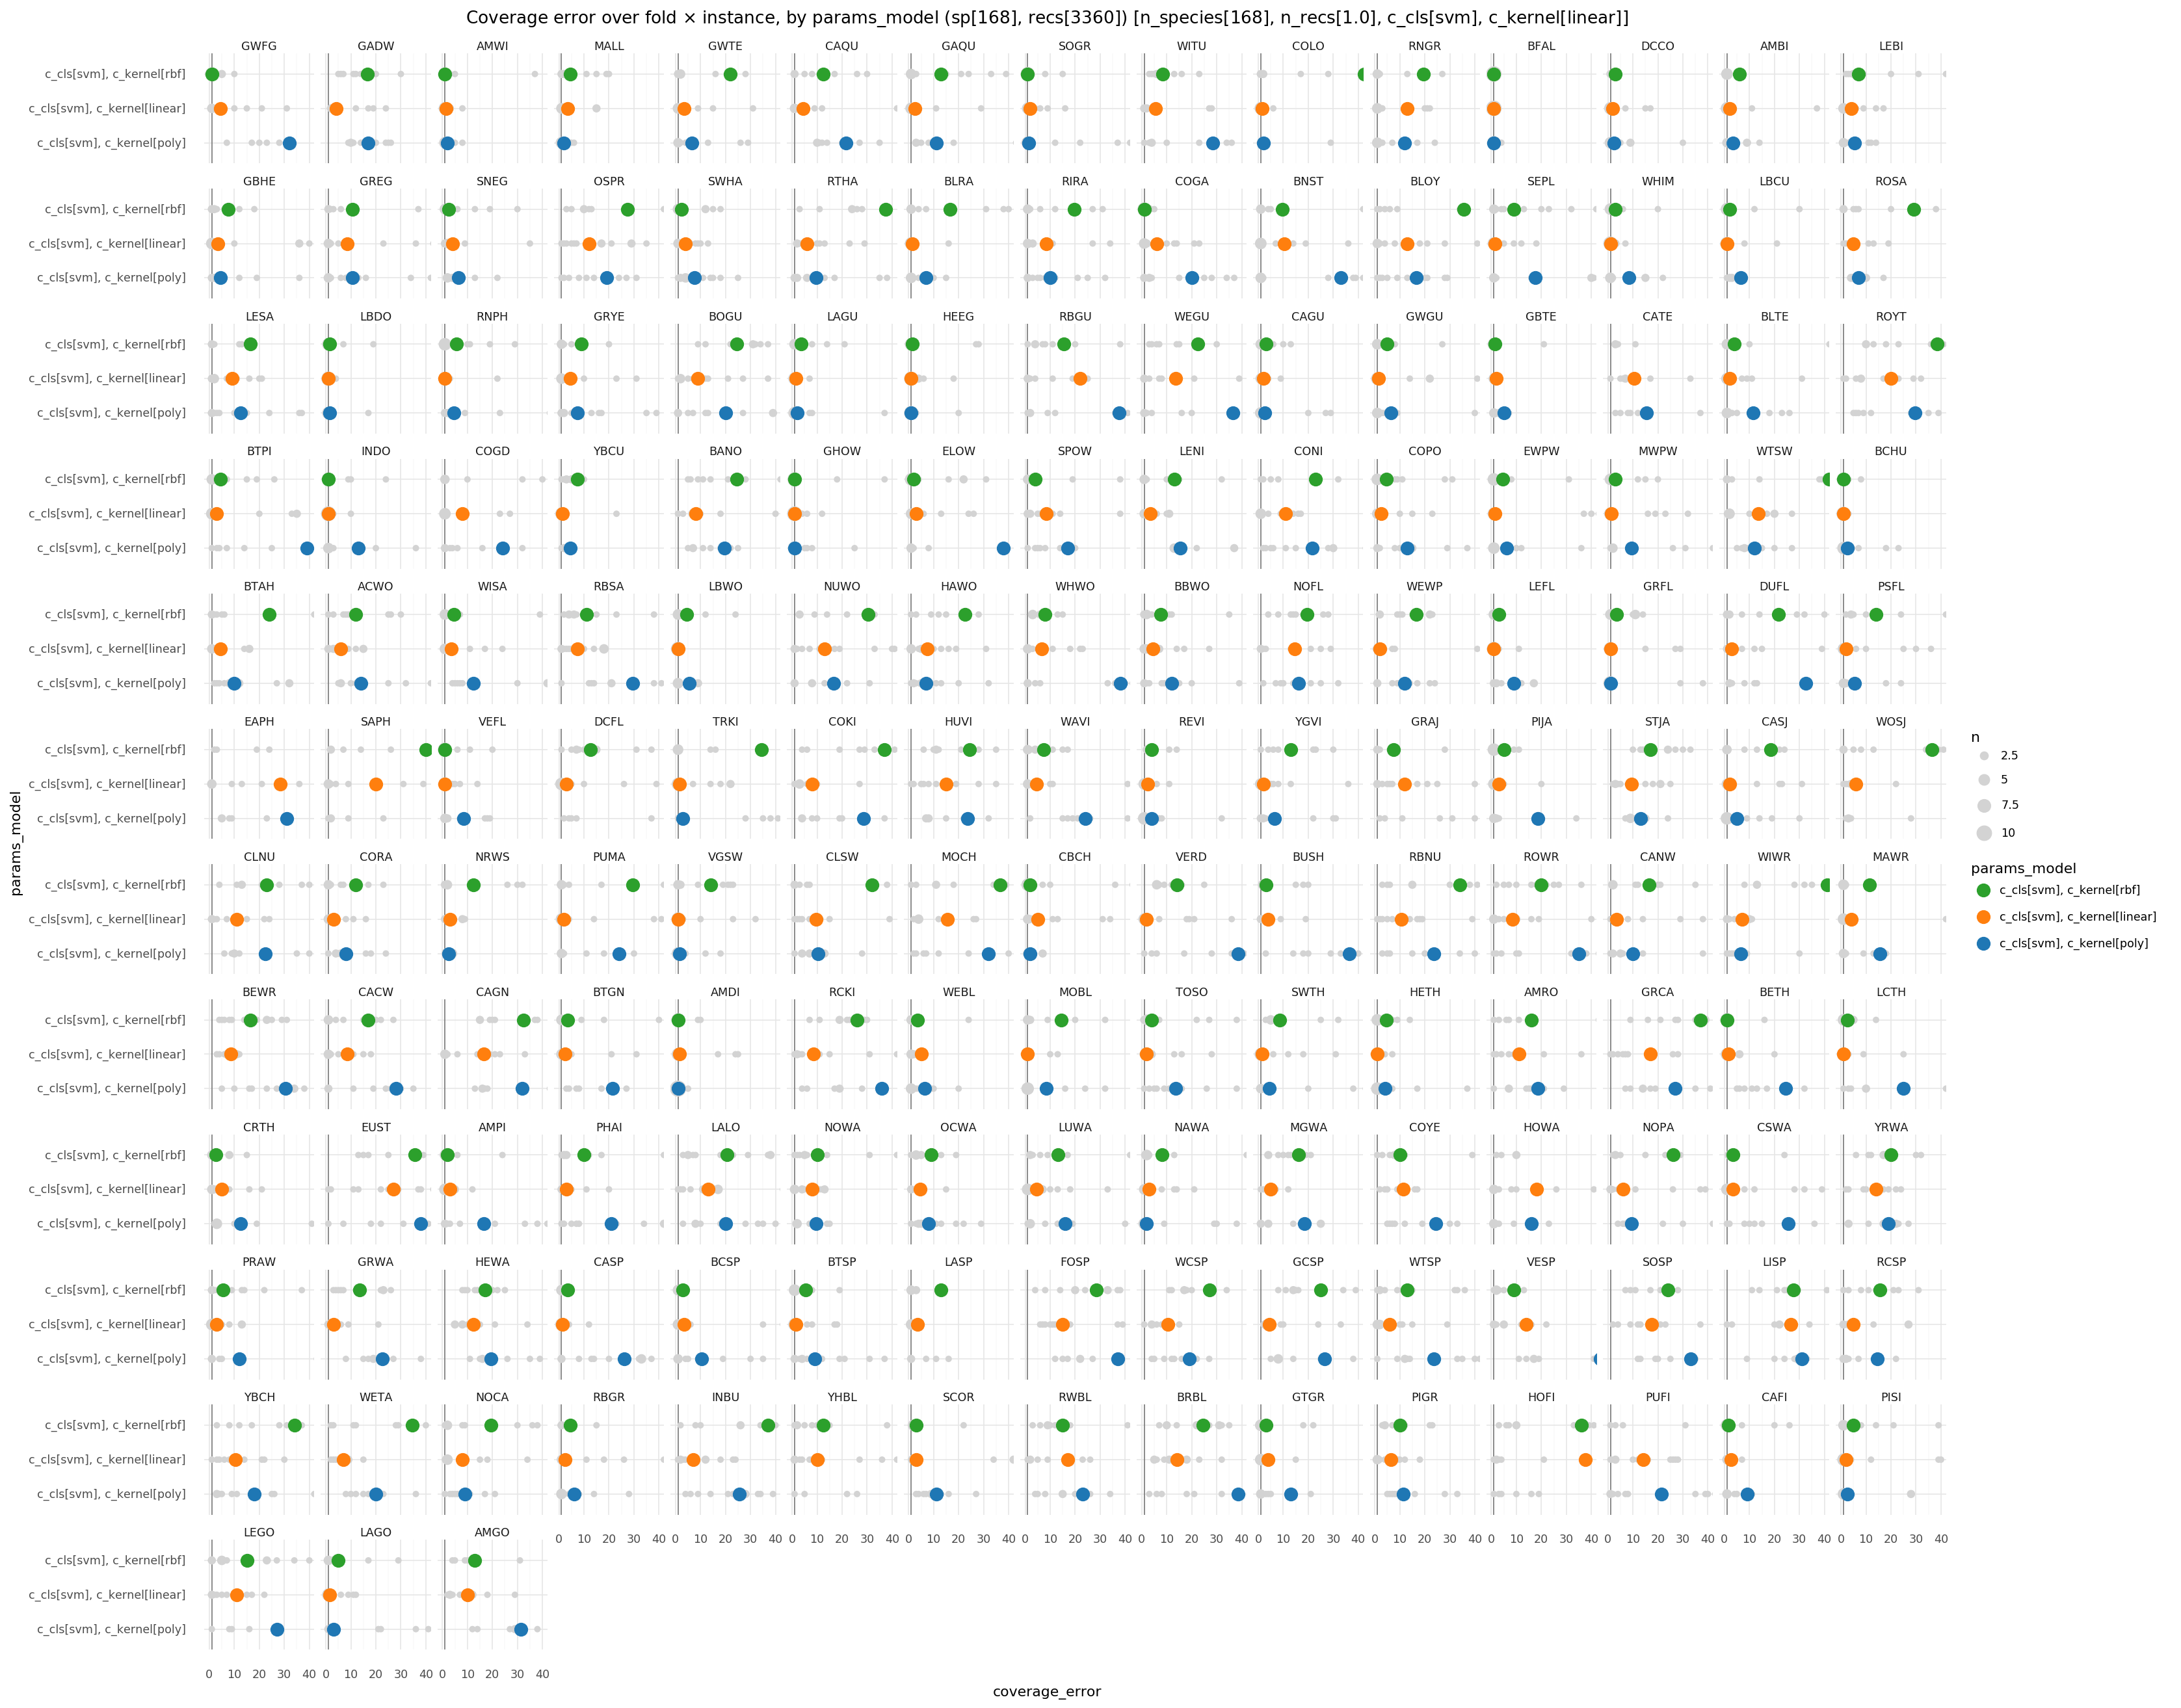

<ggplot: (-9223372036465474770)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
# params_complexity = 'c_max_depth[46]'
params_complexity = 'c_C[1]'
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_complexity == params_complexity]
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'params_model')
    .pipe(ggplot)
    + aes(x='params_model', y='coverage_error')
    + aes(color='params_model')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    + scale_color_cmap_d('tab10')  # Strong
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=24, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_model ({recs_stats}) [{params_data}, {params_model}]')
)

In [ ]:
ONE_MODEL_PLOTS_NEXT

# Model diagnostics: one model, all folds

In [ ]:
params_i = 0
params = cv_models.params.cat.categories[params_i]
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), params))
print('  fold[*/%s]' % cv.cv.n_splits)

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:5],
)

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=10, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance ({params}) ({recs_stats})')
)

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
            title=f'({recs_stats})',
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = cv_models.params.cat.categories[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id}) ({recs_stats})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
        title=f'({recs_stats})',
    )

[skip]